# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from math import sqrt
from transformers import LlamaConfig, LlamaModel, LlamaTokenizer, GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, BertModel, BertTokenizer
import transformers
import accelerate
from torch import nn, optim
import torch.nn.functional as F
from torch import Tensor
from torch.nn.utils import weight_norm
import math
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
import torch
from torchmetrics.regression import R2Score
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import BitsAndBytesConfig
from sklearn.model_selection import KFold, StratifiedKFold
import random
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.tensorboard import SummaryWriter
import time
import itertools
import ramanspy as rs
from ramanspy import preprocessing

# Model

| Parameter     | Meaning | 
|:---------|:---:|
| pred_len   | How many futuresteps the model should predict.  |    
| seq_len   | How many past time-steps are given the model as input.   |     
| d_ff     | The size of the vectors extracted from the LLM’s hidden states before the final head. This is the “feature‐for‐forecast” dimension.  |      
| patch_len     | How many consecutive time‐steps make up one patch when we slice your series.  |   
| stride     | How far you shift your sliding window between patches.   |   
| llm_layers     | How many Transformer layers we want to use from the pretrained LLM.  |   
| d_model     | The hidden‐dimensionality of your patch embeddings (the output of the Conv1d). In Transformer terms, this is the “model width.”  |   
| n_heads     | The number of attention heads in your ReprogrammingLayer.   |   
| enc_in     | Number of parallel input channels (i.e. number of series or variables).   |   
| d_llm     | The hidden‐state size of the LLM.  |   



In [3]:
class Details:
    def __init__(self, pred_len,seq_len,d_ff,stride,llm_layers,
                 description, dropout, d_model, n_heads,enc_in, patch_len, d_llm,llm_model, lr):
        self.pred_len = pred_len #Time steps to predict; 1 in our case
        self.seq_len = seq_len # length of historical input sequence
        self.d_ff = d_ff #Features extracted from the LLM hidden states
        self.patch_len = patch_len
        self.stride = stride
        self.llm_layers = llm_layers
        self.content = description
        self.dropout = dropout
        self.d_model = d_model
        self.enc_in = enc_in #number of variables ie number of parallel time series; 1 in our case becasue univariate time series
        self.n_heads = n_heads
        self.d_llm = d_llm
        self.llm_model = llm_model
        self.lr = lr

In [4]:
transformers.logging.set_verbosity_error()

class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class Model(nn.Module):
    #configs is the details of the task
    def __init__(self, configs, patch_len=16, stride=8):
        super(Model, self).__init__()
        self.pred_len = configs.pred_len
        self.seq_len = configs.seq_len
        self.d_ff = configs.d_ff
        self.top_k = 5
        self.d_llm = configs.d_llm
        self.patch_len = configs.patch_len
        self.stride = configs.stride

        if configs.llm_model == 'LLAMA':
            self.llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True

            self.llm_model = LlamaModel.from_pretrained(
                        'huggyllama/llama-7b',
                        trust_remote_code=True,
                        local_files_only=True,
                        config=self.llama_config,
                    )
            
            self.tokenizer = LlamaTokenizer.from_pretrained(
                        'huggyllama/llama-7b',
                        trust_remote_code=True,
                        local_files_only=True
                    )
        elif configs.llm_model == 'GPT2':

            self.gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')
            self.gpt2_config.num_hidden_layers = configs.llm_layers
            self.gpt2_config.output_attentions = True
            self.gpt2_config.output_hidden_states = True

            self.llm_model = GPT2Model.from_pretrained(
                        'openai-community/gpt2',
                        trust_remote_code=True,
                        #local_files_only=True,
                        config=self.gpt2_config,
                    )
            self.tokenizer = GPT2Tokenizer.from_pretrained(
                        'openai-community/gpt2',
                        trust_remote_code=True,
                        #local_files_only=True
                    )
            
        elif configs.llm_model == 'BERT':

            self.bert_config = BertConfig.from_pretrained('google-bert/bert-base-uncased')

            self.bert_config.num_hidden_layers = configs.llm_layers
            self.bert_config.output_attentions = True
            self.bert_config.output_hidden_states = True

            self.llm_model = BertModel.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.bert_config,
                )
    
            self.tokenizer = BertTokenizer.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True
                )

        else:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,  
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
            )

            self.llama_config = AutoConfig.from_pretrained("TheBloke/LLaMA-7B-GGML")
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True

            self.llm_model = AutoModel.from_pretrained(
                "TheBloke/LLaMA-7B-GGML",
                config=self.llama_config,
                device_map="auto",
                quantization_config=bnb_config,
                trust_remote_code=True,
                from_tf=True
            )

            self.tokenizer = AutoTokenizer.from_pretrained(
                "TheBloke/LLaMA-7B-GGML",
                trust_remote_code=True
            )

        
        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = '[PAD]'
            self.tokenizer.add_special_tokens({'pad_token': pad_token})
            self.tokenizer.pad_token = pad_token

        #Freeze parameters of LLM:
        for param in self.llm_model.parameters():
            param.requires_grad = False
        
        self.description = configs.content

        self.dropout = nn.Dropout(configs.dropout)

        self.patch_embedding = PatchEmbedding(
            configs.d_model, self.patch_len, self.stride, configs.dropout)

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        self.vocab_size = self.word_embeddings.shape[0]
        self.num_tokens = 1000
        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens)

        self.reprogramming_layer = ReprogrammingLayer(configs.d_model, configs.n_heads, self.d_ff, self.d_llm)


        self.patch_nums = int((configs.seq_len - self.patch_len) / self.stride + 2)
        self.head_nf = self.d_ff * self.patch_nums

        self.output_projection = FlattenHead(configs.enc_in, self.head_nf, self.pred_len, head_dropout=configs.dropout)

        self.normalize_layers = Normalize(configs.enc_in, affine=False)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
        return dec_out[:, -self.pred_len:, :]

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x_enc = self.normalize_layers(x_enc, 'norm')
        B, T, N = x_enc.size()

        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)

        min_values = torch.min(x_enc, dim=1)[0]        
        max_values = torch.max(x_enc, dim=1)[0]        
        medians = torch.median(x_enc, dim=1).values 
 
        lags = self.calcute_lags(x_enc)          
         
        trends = x_enc.diff(dim=1).sum(dim=1)      

        prompt = []
        #print(x_enc.shape[0])
        for b in range(x_enc.shape[0]):  
            min_values_str    = str(min_values[b].tolist()[0])
            max_values_str    = str(max_values[b].tolist()[0])
            median_values_str = str(medians[b].tolist()[0])
            lags_values_str   = str(lags[b].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description} "
                f"Task description: forecast the next {str(self.pred_len)} steps "
                #f"Task description: forecast the next step"
                f"given the previous {str(self.seq_len)} steps information; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {median_values_str}, "
                f"the trend of input is {'upward' if trends[b] > 0 else 'downward'}, "
                f"top 5 lags are: {lags_values_str}<|<end_prompt>|>"
            )
            prompt.append(prompt_)
            #print(prompt_)
            
        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous()

        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt.to(x_enc.device))  # (batch, prompt_token, dim)

        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0)

        x_enc = x_enc.permute(0, 2, 1).contiguous()
        enc_out, n_vars = self.patch_embedding(x_enc) #x_enc.to(torch.bfloat16)
        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)
        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state
        #print(dec_out)
        dec_out = dec_out[:, :, :self.d_ff]

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:])
        dec_out = dec_out.permute(0, 2, 1).contiguous()

        dec_out = self.normalize_layers(dec_out, 'denorm')

        return dec_out

    
    def calcute_lags(self, x_enc):
        q_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)
        mean_value = torch.mean(corr, dim=1)
        _, lags = torch.topk(mean_value, self.top_k, dim=-1)
        return lags
    

class ReprogrammingLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)
    
    def forward(self, target_embedding, source_embedding, value_embedding):
        B, L, _ = target_embedding.shape
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding
    
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class ReplicationPad1d(nn.Module):
    def __init__(self, padding) -> None:
        super(ReplicationPad1d, self).__init__()
        self.padding = padding

    def forward(self, input: Tensor) -> Tensor:
        replicate_padding = input[:, :, -1].unsqueeze(-1).repeat(1, 1, self.padding[-1])
        output = torch.cat([input, replicate_padding], dim=-1)
        return output


class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout):
        super(PatchEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = ReplicationPad1d((0, stride))

        # Backbone, Input encoding: projection of feature vectors onto a d-dim vector space
        self.value_embedding = TokenEmbedding(patch_len, d_model)

        # Positional embedding
        # self.position_embedding = PositionalEmbedding(d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # do patching
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x)
        return self.dropout(x), n_vars

class Normalize(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(Normalize, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


In [5]:
def supervised_data(data, in_length, out_length):
    X = pd.DataFrame()
    Y = pd.DataFrame()
    n = data.shape[0]
    for col in data.columns:
        x = []
        y = []
        for i in range(n - in_length - out_length + 1):
            x2 = data.loc[i:i + in_length - 1,col]
            y2 = data.loc[i + in_length:i + in_length + out_length -1,col]
            x.extend(x2)
            y.extend(y2)
        X[col] = x
        Y[col] = y
    return X, Y


Pipeline to train raman datasets only:

In [6]:
def train_model(configs, train, validation, epochs, batch_size, updates, earlystop, patience = 10):

    #Scale spectra

    train.columns = train.columns.astype(str)
    scaler = StandardScaler()
    normalized = scaler.fit_transform(train.iloc[:,1:].T).T
    X_train_n = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

    validation.columns = validation.columns.astype(str)
    normalized = scaler.fit_transform(validation.iloc[:,1:].T).T
    X_val_n = pd.DataFrame(normalized, columns = validation.iloc[:,1:].columns)

    #Scale wavelengths
    stand = StandardScaler()
    scaled = stand.fit_transform(X_train_n)
    X_train_n = pd.DataFrame(scaled, columns = X_train_n.columns)
    scaled = stand.transform(X_val_n)
    X_val_n = pd.DataFrame(scaled, columns = X_val_n.columns)
    
    #Prepare tensor dataset

    pred_len = configs.pred_len
    seq_len = configs.seq_len
    n_vars = 1
    N_train =  X_train_n.shape[0]
    N_val = X_val_n.shape[0]

    X = torch.from_numpy(X_train_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y = torch.from_numpy(train.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)
                
    X2 = torch.from_numpy(X_val_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y2 = torch.from_numpy(validation.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)
                
    train_ds = TensorDataset(X, y)
    val_ds = TensorDataset(X2, y2)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)

    #Train model 
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(configs).to(device)
    #opt = torch.optim.AdamW(model.parameters(), lr=configs.lr, weight_decay=1e-2)
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=configs.lr)
    criterion = torch.nn.MSELoss()

    num_epochs = epochs

    #Early stop

    best_val_rmse = float('inf')

    counter = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        sum_mse = 0.0
        r2_metric = R2Score()
        for x_enc, y_true in train_loader:
            x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
            opt.zero_grad()
            y_pred = model(x_enc, None, None, None)  
            loss = criterion(y_pred, y_true)
            loss.backward()
            opt.step()
            sum_mse += loss.item()*x_enc.size(0)
            #r2_metric.update(y_pred.squeeze(), y_true.squeeze())
            r2_metric.update(y_pred.reshape(-1), y_true.reshape(-1))

            del y_pred, loss  # Free up memory
            torch.cuda.empty_cache()

        train_mse = sum_mse / N_train
        train_rmse = sqrt(train_mse)
        train_r2 = r2_metric.compute()


        model.eval()
        sum_mse = 0.0
        r2_metric2 = R2Score()
        with torch.no_grad():
            for x_enc, y_true in val_loader:
                x_enc, y_true = x_enc.to(device), y_true.to(device)
                y_pred = model(x_enc, None, None, None)
                sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
                #r2_metric2.update(y_pred.squeeze(), y_true.squeeze())
                r2_metric2.update(y_pred.reshape(-1), y_true.reshape(-1))

                del y_pred  # Free up memory
                torch.cuda.empty_cache()


        val_mse = sum_mse / N_val
        val_rmse = sqrt(val_mse)
        val_r2 = r2_metric2.compute()

        #print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - val RMSE {val_rmse:.6f} ")
        if updates:
            print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
            
        if earlystop:
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                counter = 0
                torch.save(model.state_dict(), 'best_model.pt')  # Save best model
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered; Best val RMSE : {best_val_rmse:.6f}")
                    break
    return model, train_rmse, train_r2, val_rmse, val_r2, stand

# Weather Dataset

In [7]:
weather = pd.read_csv('weather.csv')
weather['date'] = pd.to_datetime(weather['date'], dayfirst= False)
weather
del weather['date']

#weather = weather.iloc[:1000,:10]

In [8]:
train_N = round(weather.shape[0]*0.8)
train_N

42157

Train-Validation Split

In [9]:
train = weather.iloc[:train_N,:]
test = weather.iloc[train_N:,:].reset_index(drop=True)

In [10]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns = weather.columns)
test = pd.DataFrame(test, columns = weather.columns)

In [11]:
train.shape

(42157, 21)

Task details:

In [14]:
pred_len = 96
seq_len = 512
n_vars = len(train.columns)
configs = Details(
    pred_len = pred_len,      
    seq_len  = seq_len,
    d_ff = 32,
    patch_len= 16,
    stride = 8, 
    llm_layers = 32,
    description = "Weather is recorded every 10 minutes for the 2020 whole year, which contains 21 meteorological indicators, such as air temperature, humidity, etc." ,
    dropout = 0.1,
    n_heads = 8,
    d_model = 16,
    enc_in = n_vars,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 1e-3
)


In [12]:
X_train, Y_train = supervised_data(train, seq_len, pred_len)
X_test, Y_test = supervised_data(test, seq_len, pred_len)

In [12]:
X_train.shape

(21273600, 21)

In [13]:
N_train = int(X_train.shape[0]/seq_len)
X_train_ = torch.from_numpy(X_train.to_numpy().astype('float32')).view(N_train, seq_len, n_vars)
Y_train_ = torch.from_numpy(Y_train.to_numpy().astype('float32')).view(N_train, pred_len, n_vars)

N_test = int(X_test.shape[0]/seq_len)
X_test_ = torch.from_numpy(X_test.to_numpy().astype('float32')).view(N_test, seq_len, n_vars)
Y_test_ = torch.from_numpy(Y_test.to_numpy().astype('float32')).view(N_test, pred_len, n_vars)
       
train_ds = TensorDataset(X_train_, Y_train_)
test_ds = TensorDataset(X_test_, Y_test_)

batch_size   = 16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)#Or should it be true¿?
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=configs.lr)
criterion = torch.nn.MSELoss()

num_epochs = 100

for epoch in range(1, num_epochs+1):
    model.train()
    sum_mse = 0.0
    r2_metric = R2Score()
    for x_enc, y_true in train_loader:
        x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
        opt.zero_grad()
        y_pred = model(x_enc, None, None, None)  
        loss = criterion(y_pred, y_true)
        loss.backward()
        opt.step()
        sum_mse += loss.item()*x_enc.size(0)
        r2_metric.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
        del y_pred, loss  # Free up memory
        torch.cuda.empty_cache()

    train_mse = sum_mse / N_train
    train_rmse = sqrt(train_mse)
    train_r2 = r2_metric.compute()


    model.eval()
    sum_mse = 0.0
    r2_metric2 = R2Score()
    with torch.no_grad():
        for x_enc, y_true in test_loader:
            x_enc, y_true = x_enc.to(device), y_true.to(device)
            y_pred = model(x_enc, None, None, None)
            sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
            r2_metric2.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
            del y_pred  # Free up memory
            torch.cuda.empty_cache()


    val_mse = sum_mse / N_test
    val_rmse = sqrt(val_mse)
    val_r2 = r2_metric2.compute()


    print(f"Epoch {epoch:2d} — train MSE {train_mse:.6f} - train R2 {train_r2:.6f} — val MSE {val_mse:.6f} - val R2 {val_r2:.6f}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 670.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 164.69 MiB is free. Including non-PyTorch memory, this process has 23.32 GiB memory in use. Of the allocated memory 20.88 GiB is allocated by PyTorch, and 1.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Don't run this

In [16]:
num_epochs = 5

for epoch in range(1, num_epochs+1):
    model.train()
    sum_mse = 0.0
    r2_metric = R2Score()
    for x_enc, y_true in train_loader:
        x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
        opt.zero_grad()
        y_pred = model(x_enc, None, None, None)  
        loss = criterion(y_pred, y_true)
        loss.backward()
        opt.step()
        sum_mse += loss.item()*x_enc.size(0)
        r2_metric.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
        del y_pred, loss  # Free up memory
        torch.cuda.empty_cache()

    train_mse = sum_mse / N_train
    train_rmse = sqrt(train_mse)
    train_r2 = r2_metric.compute()


    model.eval()
    sum_mse = 0.0
    r2_metric2 = R2Score()
    with torch.no_grad():
        for x_enc, y_true in test_loader:
            x_enc, y_true = x_enc.to(device), y_true.to(device)
            y_pred = model(x_enc, None, None, None)
            sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
            r2_metric2.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
            del y_pred  # Free up memory
            torch.cuda.empty_cache()


    val_mse = sum_mse / N_test
    val_rmse = sqrt(val_mse)
    val_r2 = r2_metric2.compute()


    print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")


Epoch  1 — train RMSE 3.204922 - train R2 0.399476 — val RMSE 1.529246 - val R2 0.512537
Epoch  2 — train RMSE 2.215803 - train R2 0.716460 — val RMSE 1.060983 - val R2 0.767389
Epoch  3 — train RMSE 1.815567 - train R2 0.791040 — val RMSE 1.022648 - val R2 0.787486
Epoch  4 — train RMSE 1.765228 - train R2 0.801854 — val RMSE 1.020342 - val R2 0.798367
Epoch  5 — train RMSE 1.768999 - train R2 0.802592 — val RMSE 1.010477 - val R2 0.806963


scaled data

Dont run this

In [33]:
num_epochs = 5

for epoch in range(1, num_epochs+1):
    model.train()
    sum_mse = 0.0
    r2_metric = R2Score()
    for x_enc, y_true in train_loader:
        x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
        opt.zero_grad()
        y_pred = model(x_enc, None, None, None)  
        loss = criterion(y_pred, y_true)
        loss.backward()
        opt.step()
        sum_mse += loss.item()*x_enc.size(0)
        r2_metric.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
        del y_pred, loss  # Free up memory
        torch.cuda.empty_cache()

    train_mse = sum_mse / N_train
    train_rmse = sqrt(train_mse)
    train_r2 = r2_metric.compute()


    model.eval()
    sum_mse = 0.0
    r2_metric2 = R2Score()
    with torch.no_grad():
        for x_enc, y_true in test_loader:
            x_enc, y_true = x_enc.to(device), y_true.to(device)
            y_pred = model(x_enc, None, None, None)
            sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
            r2_metric2.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
            del y_pred  # Free up memory
            torch.cuda.empty_cache()


    val_mse = sum_mse / N_test
    val_rmse = sqrt(val_mse)
    val_r2 = r2_metric2.compute()


    print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 244.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 251.81 MiB is free. Including non-PyTorch memory, this process has 23.22 GiB memory in use. Of the allocated memory 20.84 GiB is allocated by PyTorch, and 1.11 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Illness dataset

In [15]:
ill = pd.read_csv('national_illness.csv')
del ill['date']

ill

,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,1.222620,1.166680,582,805,2060,754,176569
1,1.333440,1.216500,683,872,2267,785,186355
2,1.319290,1.130570,642,878,2176,831,192469
3,1.494840,1.252460,728,1045,2599,863,207512
4,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...
961,0.839059,0.846722,2756,3528,12913,3258,1525058
962,0.895958,0.908885,3203,3778,13979,3254,1538038
963,0.910926,0.941625,3478,3796,14389,3177,1528103
964,0.946945,0.972185,3734,3818,14999,3066,1542813


Train-test split

In [16]:
train_N = round(ill.shape[0]*0.8)
train = ill.iloc[:train_N,:]
test = ill.iloc[train_N:,:].reset_index(drop=True)

In [17]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns = ill.columns)
test = pd.DataFrame(test, columns = ill.columns)

In [18]:
pred_len = 24
seq_len = 96
n_vars = len(train.columns)
configs = Details(
    pred_len = pred_len,      
    seq_len  = seq_len,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 32,
    description = "weekly U.S. influenza-like illness (ILI) surveillance data, " \
    "including weighted and unweighted ILI percentages, age-specific case counts, total cases, " \
    "number of reporting providers, and outpatient visits.",
    dropout = 0.1,
    n_heads = 8,
    d_model = 16,
    enc_in = n_vars,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 1e-2
)


In [9]:
X_train, Y_train = supervised_data(train, seq_len, pred_len)
X_test, Y_test = supervised_data(test, seq_len, pred_len)

In [10]:
N_train = int(X_train.shape[0]/seq_len)
X_train_ = torch.from_numpy(X_train.to_numpy().astype('float32')).view(N_train, seq_len, n_vars)
Y_train_ = torch.from_numpy(Y_train.to_numpy().astype('float32')).view(N_train, pred_len, n_vars)

N_test = int(X_test.shape[0]/seq_len)
X_test_ = torch.from_numpy(X_test.to_numpy().astype('float32')).view(N_test, seq_len, n_vars)
Y_test_ = torch.from_numpy(Y_test.to_numpy().astype('float32')).view(N_test, pred_len, n_vars)
       
train_ds = TensorDataset(X_train_, Y_train_)
test_ds = TensorDataset(X_test_, Y_test_)

batch_size   = 16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)#Or should it be true
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=configs.lr)
criterion = torch.nn.MSELoss()

num_epochs = 50

for epoch in range(1, num_epochs+1):
    model.train()
    sum_mse = 0.0
    r2_metric = R2Score()
    for x_enc, y_true in train_loader:
        x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
        opt.zero_grad()
        y_pred = model(x_enc, None, None, None)  
        loss = criterion(y_pred, y_true)
        loss.backward()
        opt.step()
        sum_mse += loss.item()*x_enc.size(0)
        r2_metric.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
        del y_pred, loss  # Free up memory
        torch.cuda.empty_cache()

    train_mse = sum_mse / N_train
    train_rmse = sqrt(train_mse)
    train_r2 = r2_metric.compute()


    model.eval()
    sum_mse = 0.0
    r2_metric2 = R2Score()
    with torch.no_grad():
        for x_enc, y_true in test_loader:
            x_enc, y_true = x_enc.to(device), y_true.to(device)
            y_pred = model(x_enc, None, None, None)
            sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
            r2_metric2.update(y_pred.reshape(-1, n_vars), y_true.reshape(-1, n_vars))
            del y_pred  # Free up memory
            torch.cuda.empty_cache()


    val_mse = sum_mse / N_test
    val_rmse = sqrt(val_mse)
    val_r2 = r2_metric2.compute()


    print(f"Epoch {epoch:2d} — train MSE {train_mse:.6f} - train R2 {train_r2:.6f} — val MSE {val_mse:.6f} - val R2 {val_r2:.6f}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

: 

# Lactate Dataset

In [6]:
data = pd.read_excel("DataFrame_PathLen.xlsx", index_col=0)
start_columns = data.columns[:2]
end_columns = data.columns[-8:]
data = data.drop(columns=end_columns)
reversed_columns = list(data.columns[2:][::-1])
data = pd.concat([data[start_columns], data[reversed_columns]], axis=1)
data= data[data['PathLength'] == 5].reset_index(drop=True)
data= data.drop(columns='PathLength')
data

,Concentration,1014.08,1015.85,1017.62,1019.4,1021.19,1022.98,1024.77,1026.58,1028.39,...,2481.26,2491.87,2502.56,2513.35,2524.23,2535.2,2546.27,2557.44,2568.71,2580.07
0,0.0,-0.005231,0.038095,0.082302,0.082237,0.076576,0.106940,0.095478,0.089268,0.086707,...,0.026194,0.021901,0.019588,0.029467,0.030502,0.012769,0.000612,-0.015370,-0.047555,-0.068557
1,0.0,-0.081353,-0.131399,-0.160719,-0.190526,-0.224999,-0.239949,-0.231437,-0.181605,-0.190708,...,0.012446,0.048297,0.064985,0.043647,0.008629,-0.035054,-0.086570,-0.152690,-0.234232,-0.326223
2,0.0,-0.143674,-0.116576,-0.123858,-0.097288,-0.035242,0.023129,0.056915,0.098068,0.075592,...,0.011739,-0.003521,-0.014063,-0.008997,0.002582,0.017829,0.048742,0.084157,0.115354,0.151298
3,0.0,0.096424,0.010348,0.037800,0.007231,-0.021712,-0.037742,-0.082596,-0.089286,-0.070054,...,0.091157,0.068864,0.056702,0.034800,0.020370,0.016746,0.001978,0.007347,0.025432,0.049032
4,0.0,0.013245,0.088878,0.055112,0.057282,0.044607,0.047680,0.033936,0.050192,0.005173,...,0.074989,0.022504,-0.014653,-0.054191,-0.089806,-0.118453,-0.134508,-0.148832,-0.151126,-0.144606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,1300.0,0.013892,-0.023256,-0.031826,-0.053169,-0.084421,-0.100099,-0.078321,-0.081930,-0.054463,...,0.149447,0.165580,0.169533,0.151979,0.127341,0.088787,0.039029,-0.012803,-0.064349,-0.110492
352,1300.0,-0.300830,-0.334294,-0.300479,-0.285832,-0.234678,-0.182459,-0.151797,-0.119183,-0.052906,...,0.063646,0.027490,0.003725,-0.002946,0.010705,0.029308,0.049670,0.079636,0.110156,0.135482
353,1300.0,-0.199545,-0.220742,-0.222265,-0.198332,-0.153330,-0.132572,-0.199724,-0.168876,-0.109947,...,0.096368,0.073663,0.063638,0.061432,0.066310,0.063311,0.060929,0.077316,0.088265,0.111251
354,1300.0,-0.107494,-0.126795,-0.182586,-0.215886,-0.246338,-0.249917,-0.254625,-0.288691,-0.253613,...,0.123685,0.132682,0.137421,0.141735,0.143292,0.140572,0.137399,0.136859,0.126693,0.115020


## Without log output

In [7]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [11]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 694.820907 - train R2 -0.512214 — val RMSE 677.650168 - val R2 -0.456397
Epoch  2 — train RMSE 674.128013 - train R2 -0.423483 — val RMSE 649.996659 - val R2 -0.339958
Epoch  3 — train RMSE 653.317432 - train R2 -0.336953 — val RMSE 625.962241 - val R2 -0.242697
Epoch  4 — train RMSE 630.227815 - train R2 -0.244121 — val RMSE 612.132141 - val R2 -0.188390
Epoch  5 — train RMSE 612.597808 - train R2 -0.175489 — val RMSE 592.192200 - val R2 -0.112229
Epoch  6 — train RMSE 591.924406 - train R2 -0.097489 — val RMSE 568.059519 - val R2 -0.023426
Epoch  7 — train RMSE 582.272246 - train R2 -0.061988 — val RMSE 543.591324 - val R2 0.062840
Epoch  8 — train RMSE 546.298650 - train R2 0.065181 — val RMSE 531.960334 - val R2 0.102515
Epoch  9 — train RMSE 543.913451 - train R2 0.073326 — val RMSE 489.160533 - val R2 0.241123
Epoch 10 — train RMSE 508.329423 - train R2 0.190610 — val RMSE 468.475753 - val R2 0.303946
Epoch 11 — train RMSE 472.085978 - train R2 0.301913 — va

AdamW optimizer

In [9]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 694.929570 - train R2 -0.512687 — val RMSE 677.987152 - val R2 -0.457846
Epoch  2 — train RMSE 675.280576 - train R2 -0.428355 — val RMSE 651.173052 - val R2 -0.344812
Epoch  3 — train RMSE 646.699582 - train R2 -0.310004 — val RMSE 624.521973 - val R2 -0.236984
Epoch  4 — train RMSE 630.123120 - train R2 -0.243708 — val RMSE 609.046283 - val R2 -0.176439
Epoch  5 — train RMSE 607.373771 - train R2 -0.155526 — val RMSE 589.370122 - val R2 -0.101654
Epoch  6 — train RMSE 593.205450 - train R2 -0.102244 — val RMSE 563.827060 - val R2 -0.008232
Epoch  7 — train RMSE 580.267099 - train R2 -0.054686 — val RMSE 545.140628 - val R2 0.057490
Epoch  8 — train RMSE 545.788180 - train R2 0.066927 — val RMSE 517.426342 - val R2 0.150886
Epoch  9 — train RMSE 526.253585 - train R2 0.132523 — val RMSE 489.986125 - val R2 0.238559
Epoch 10 — train RMSE 510.303284 - train R2 0.184312 — val RMSE 473.523214 - val R2 0.288866
Epoch 11 — train RMSE 506.561824 - train R2 0.196229 — va

Early stoppage

In [16]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 696.442279 - train R2 -0.519280 — val RMSE 680.736659 - val R2 -0.469694
Epoch  2 — train RMSE 680.189913 - train R2 -0.449199 — val RMSE 654.011342 - val R2 -0.356561
Epoch  3 — train RMSE 646.097220 - train R2 -0.307565 — val RMSE 625.543689 - val R2 -0.241035
Epoch  4 — train RMSE 624.219410 - train R2 -0.220512 — val RMSE 606.575306 - val R2 -0.166912
Epoch  5 — train RMSE 615.523687 - train R2 -0.186744 — val RMSE 592.219719 - val R2 -0.112332
Epoch  6 — train RMSE 598.146050 - train R2 -0.120681 — val RMSE 570.224647 - val R2 -0.031242
Epoch  7 — train RMSE 576.905917 - train R2 -0.042504 — val RMSE 544.326609 - val R2 0.060303
Epoch  8 — train RMSE 534.136505 - train R2 0.106341 — val RMSE 517.906283 - val R2 0.149310
Epoch  9 — train RMSE 530.565854 - train R2 0.118249 — val RMSE 487.323478 - val R2 0.246812
Epoch 10 — train RMSE 484.830560 - train R2 0.263712 — val RMSE 465.582427 - val R2 0.312517
Epoch 11 — train RMSE 474.501903 - train R2 0.294750 — va

New config

In [7]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 16, #increased
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 4, #increased
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001
)

In [8]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 84.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 34.50 MiB is free. Including non-PyTorch memory, this process has 23.41 GiB memory in use. Of the allocated memory 21.21 GiB is allocated by PyTorch, and 956.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Epoch  1 — train RMSE 647.933455 - train R2 -0.315008 — val RMSE 590.783431 - val R2 -0.106943
Epoch  2 — train RMSE 554.334365 - train R2 0.037477 — val RMSE 519.252565 - val R2 0.144882
Epoch  3 — train RMSE 526.764650 - train R2 0.130838 — val RMSE 427.802442 - val R2 0.419563
Epoch  4 — train RMSE 405.918747 - train R2 0.483886 — val RMSE 242.420577 - val R2 0.813616
Epoch  5 — train RMSE 259.992053 - train R2 0.788267 — val RMSE 111.821413 - val R2 0.960343
Epoch  6 — train RMSE 225.142789 - train R2 0.841224 — val RMSE 78.034123 - val R2 0.980687
Epoch  7 — train RMSE 225.829603 - train R2 0.840254 — val RMSE 87.608671 - val R2 0.975658
Epoch  8 — train RMSE 239.649822 - train R2 0.820104 — val RMSE 103.283298 - val R2 0.966168
Epoch  9 — train RMSE 218.162494 - train R2 0.850917 — val RMSE 96.721934 - val R2 0.970330
Epoch 10 — train RMSE 262.254871 - train R2 0.784566 — val RMSE 204.681310 - val R2 0.867131
Epoch 11 — train RMSE 284.733322 - train R2 0.746052 — val RMSE 217.162258 - val R2 0.850432
Epoch 12 — train RMSE 273.583936 - train R2 0.765551 — val RMSE 111.706636 - val R2 0.960424
Epoch 13 — train RMSE 244.976271 - train R2 0.812018 — val RMSE 132.690155 - val R2 0.944160
Epoch 14 — train RMSE 232.132526 - train R2 0.831213 — val RMSE 81.462859 - val R2 0.978953
Epoch 15 — train RMSE 186.777658 - train R2 0.890726 — val RMSE 99.534035 - val R2 0.968580
Epoch 16 — train RMSE 273.329657 - train R2 0.765986 — val RMSE 74.748253 - val R2 0.982280
Epoch 17 — train RMSE 189.396052 - train R2 0.887641 — val RMSE 95.888920 - val R2 0.970839
Epoch 18 — train RMSE 274.031313 - train R2 0.764783 — val RMSE 128.773256 - val R2 0.947408
Epoch 19 — train RMSE 212.659864 - train R2 0.858343 — val RMSE 59.524765 - val R2 0.988763
Epoch 20 — train RMSE 259.917481 - train R2 0.788389 — val RMSE 98.310219 - val R2 0.969347
Epoch 21 — train RMSE 222.779508 - train R2 0.844540 — val RMSE 67.700090 - val R2 0.985464
Epoch 22 — train RMSE 222.768471 - train R2 0.844556 — val RMSE 65.380988 - val R2 0.986443
Epoch 23 — train RMSE 236.554575 - train R2 0.824721 — val RMSE 57.695442 - val R2 0.989443
Epoch 24 — train RMSE 225.247918 - train R2 0.841076 — val RMSE 82.387769 - val R2 0.978472
Epoch 25 — train RMSE 236.934763 - train R2 0.824157 — val RMSE 67.392820 - val R2 0.985596
Epoch 26 — train RMSE 248.071697 - train R2 0.807238 — val RMSE 78.450618 - val R2 0.980481
Epoch 27 — train RMSE 210.518964 - train R2 0.861181 — val RMSE 57.891505 - val R2 0.989371
Epoch 28 — train RMSE 195.953701 - train R2 0.879725 — val RMSE 89.896251 - val R2 0.974370
Epoch 29 — train RMSE 195.274108 - train R2 0.880558 — val RMSE 50.932884 - val R2 0.991773
Epoch 30 — train RMSE 222.186458 - train R2 0.845367 — val RMSE 62.777909 - val R2 0.987501
Epoch 31 — train RMSE 177.366306 - train R2 0.901461 — val RMSE 58.224725 - val R2 0.989248
Epoch 32 — train RMSE 191.663961 - train R2 0.884934 — val RMSE 51.307647 - val R2 0.991651
Epoch 33 — train RMSE 140.003503 - train R2 0.938603 — val RMSE 65.591855 - val R2 0.986355
Epoch 34 — train RMSE 207.488315 - train R2 0.865149 — val RMSE 58.179779 - val R2 0.989265
Epoch 35 — train RMSE 192.416205 - train R2 0.884029 — val RMSE 49.677407 - val R2 0.992173
Epoch 36 — train RMSE 246.397685 - train R2 0.809831 — val RMSE 83.766312 - val R2 0.977746
Epoch 37 — train RMSE 195.741398 - train R2 0.879986 — val RMSE 64.266039 - val R2 0.986901
Epoch 38 — train RMSE 252.020815 - train R2 0.801052 — val RMSE 62.718037 - val R2 0.987525
Epoch 39 — train RMSE 260.489098 - train R2 0.787457 — val RMSE 87.761534 - val R2 0.975573
Epoch 40 — train RMSE 270.706953 - train R2 0.770456 — val RMSE 73.990626 - val R2 0.982637
Epoch 41 — train RMSE 193.077308 - train R2 0.883230 — val RMSE 62.386516 - val R2 0.987656
Epoch 42 — train RMSE 222.709220 - train R2 0.844638 — val RMSE 56.211224 - val R2 0.989979
Epoch 43 — train RMSE 193.706473 - train R2 0.882468 — val RMSE 68.752004 - val R2 0.985009
Epoch 44 — train RMSE 160.370031 - train R2 0.919441 — val RMSE 54.623470 - val R2 0.990537
Epoch 45 — train RMSE 233.484939 - train R2 0.829240 — val RMSE 71.820866 - val R2 0.983640
Epoch 46 — train RMSE 208.150687 - train R2 0.864286 — val RMSE 66.932094 - val R2 0.985792
Epoch 47 — train RMSE 221.307029 - train R2 0.846588 — val RMSE 70.514370 - val R2 0.984230
Epoch 48 — train RMSE 193.526990 - train R2 0.882686 — val RMSE 66.622031 - val R2 0.985923
Epoch 49 — train RMSE 177.295699 - train R2 0.901539 — val RMSE 73.677913 - val R2 0.982784
Epoch 50 — train RMSE 194.113478 - train R2 0.881974 — val RMSE 76.524885 - val R2 0.981427
Epoch 51 — train RMSE 234.503027 - train R2 0.827748 — val RMSE 67.803062 - val R2 0.985420
Epoch 52 — train RMSE 246.821589 - train R2 0.809176 — val RMSE 68.505124 - val R2 0.985116
Epoch 53 — train RMSE 206.986450 - train R2 0.865800 — val RMSE 56.618211 - val R2 0.989833
Epoch 54 — train RMSE 257.492518 - train R2 0.792319 — val RMSE 66.517137 - val R2 0.985967
Epoch 55 — train RMSE 220.718738 - train R2 0.847403 — val RMSE 67.874026 - val R2 0.985389
Epoch 56 — train RMSE 221.465702 - train R2 0.846368 — val RMSE 61.709236 - val R2 0.987923
Epoch 57 — train RMSE 233.576072 - train R2 0.829107 — val RMSE 66.964073 - val R2 0.985778
Epoch 58 — train RMSE 257.642484 - train R2 0.792077 — val RMSE 58.672171 - val R2 0.989082
Epoch 59 — train RMSE 177.827767 - train R2 0.900947 — val RMSE 70.909587 - val R2 0.984053
Epoch 60 — train RMSE 176.563579 - train R2 0.902351 — val RMSE 50.410932 - val R2 0.991940
Epoch 61 — train RMSE 205.035570 - train R2 0.868318 — val RMSE 62.451023 - val R2 0.987631
Epoch 62 — train RMSE 232.925949 - train R2 0.830057 — val RMSE 56.260436 - val R2 0.989961
Epoch 63 — train RMSE 257.318634 - train R2 0.792599 — val RMSE 51.317448 - val R2 0.991648
Epoch 64 — train RMSE 246.144955 - train R2 0.810220 — val RMSE 57.359755 - val R2 0.989565
Epoch 65 — train RMSE 245.645796 - train R2 0.810989 — val RMSE 56.545341 - val R2 0.989859
Epoch 66 — train RMSE 246.225224 - train R2 0.810097 — val RMSE 68.738537 - val R2 0.985015
Epoch 67 — train RMSE 258.143453 - train R2 0.791268 — val RMSE 74.796053 - val R2 0.982257
Epoch 68 — train RMSE 257.183617 - train R2 0.792817 — val RMSE 58.010287 - val R2 0.989327
Epoch 69 — train RMSE 176.315585 - train R2 0.902625 — val RMSE 53.946784 - val R2 0.990770
Epoch 70 — train RMSE 268.406021 - train R2 0.774341 — val RMSE 47.917516 - val R2 0.992718
Epoch 71 — train RMSE 158.687798 - train R2 0.921122 — val RMSE 54.538018 - val R2 0.990567
Epoch 72 — train RMSE 207.091296 - train R2 0.865664 — val RMSE 62.547627 - val R2 0.987592
Epoch 73 — train RMSE 207.313206 - train R2 0.865376 — val RMSE 63.649774 - val R2 0.987151
Epoch 74 — train RMSE 233.869369 - train R2 0.828678 — val RMSE 48.378893 - val R2 0.992577
Epoch 75 — train RMSE 207.293031 - train R2 0.865403 — val RMSE 49.218000 - val R2 0.992317
Epoch 76 — train RMSE 221.727798 - train R2 0.846005 — val RMSE 64.252048 - val R2 0.986907
Epoch 77 — train RMSE 175.968764 - train R2 0.903007 — val RMSE 54.083346 - val R2 0.990723
Epoch 78 — train RMSE 206.299465 - train R2 0.866690 — val RMSE 62.655637 - val R2 0.987549
Epoch 79 — train RMSE 220.535845 - train R2 0.847656 — val RMSE 52.221089 - val R2 0.991351
Epoch 80 — train RMSE 232.751398 - train R2 0.830312 — val RMSE 48.730239 - val R2 0.992469
Epoch 81 — train RMSE 191.753990 - train R2 0.884825 — val RMSE 48.250687 - val R2 0.992616
Epoch 82 — train RMSE 234.538251 - train R2 0.827696 — val RMSE 51.232930 - val R2 0.991675
Epoch 83 — train RMSE 267.974160 - train R2 0.775067 — val RMSE 63.712996 - val R2 0.987126
Epoch 84 — train RMSE 289.398406 - train R2 0.737663 — val RMSE 55.629509 - val R2 0.990185
Epoch 85 — train RMSE 279.228745 - train R2 0.755776 — val RMSE 43.946445 - val R2 0.993875
Epoch 86 — train RMSE 245.837264 - train R2 0.810695 — val RMSE 58.499524 - val R2 0.989146
Epoch 87 — train RMSE 244.719813 - train R2 0.812412 — val RMSE 63.712965 - val R2 0.987126
Epoch 88 — train RMSE 219.288635 - train R2 0.849374 — val RMSE 60.452224 - val R2 0.988410
Epoch 89 — train RMSE 256.419968 - train R2 0.794046 — val RMSE 44.369312 - val R2 0.993756
Epoch 90 — train RMSE 191.022641 - train R2 0.885702 — val RMSE 56.342505 - val R2 0.989932
Epoch 91 — train RMSE 220.675689 - train R2 0.847463 — val RMSE 66.351615 - val R2 0.986037
Epoch 92 — train RMSE 278.484414 - train R2 0.757077 — val RMSE 48.916995 - val R2 0.992411
Epoch 93 — train RMSE 259.067124 - train R2 0.789771 — val RMSE 70.129189 - val R2 0.984402
Epoch 94 — train RMSE 269.145029 - train R2 0.773097 — val RMSE 59.313521 - val R2 0.988842
Epoch 95 — train RMSE 257.527233 - train R2 0.792263 — val RMSE 68.189781 - val R2 0.985253
Epoch 96 — train RMSE 233.824828 - train R2 0.828743 — val RMSE 47.819657 - val R2 0.992748
Epoch 97 — train RMSE 280.761518 - train R2 0.753088 — val RMSE 45.924158 - val R2 0.993311
Epoch 98 — train RMSE 177.906563 - train R2 0.900859 — val RMSE 52.388500 - val R2 0.991296
Epoch 99 — train RMSE 322.090981 - train R2 0.675044 — val RMSE 333.826504 - val R2 0.646564
Epoch 100 — train RMSE 279.152773 - train R2 0.755909 — val RMSE 166.940327 - val R2 0.911612

Different config

In [6]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, #increased
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [7]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 16, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 698.529635 - train R2 -0.528401 — val RMSE 686.871303 - val R2 -0.496303
Epoch  2 — train RMSE 692.385459 - train R2 -0.501631 — val RMSE 678.774838 - val R2 -0.461236
Epoch  3 — train RMSE 682.929578 - train R2 -0.460896 — val RMSE 668.664212 - val R2 -0.418029
Epoch  4 — train RMSE 670.880472 - train R2 -0.409801 — val RMSE 655.785812 - val R2 -0.363932
Epoch  5 — train RMSE 655.931472 - train R2 -0.347673 — val RMSE 642.891199 - val R2 -0.310822
Epoch  6 — train RMSE 646.518512 - train R2 -0.309271 — val RMSE 631.273131 - val R2 -0.263873
Epoch  7 — train RMSE 638.474735 - train R2 -0.276894 — val RMSE 621.695929 - val R2 -0.225815
Epoch  8 — train RMSE 632.362440 - train R2 -0.252563 — val RMSE 614.541979 - val R2 -0.197766
Epoch  9 — train RMSE 621.447047 - train R2 -0.209695 — val RMSE 605.453872 - val R2 -0.162602
Epoch 10 — train RMSE 617.888078 - train R2 -0.195879 — val RMSE 599.424086 - val R2 -0.139560
Epoch 11 — train RMSE 603.538415 - train R2 -0.140

In [6]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 10,#increased
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [7]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 696.926833 - train R2 -0.521395 — val RMSE 682.083051 - val R2 -0.475514
Epoch  2 — train RMSE 681.566362 - train R2 -0.455070 — val RMSE 663.005962 - val R2 -0.394131
Epoch  3 — train RMSE 662.701806 - train R2 -0.375637 — val RMSE 643.593998 - val R2 -0.313690
Epoch  4 — train RMSE 642.290885 - train R2 -0.292204 — val RMSE 626.815762 - val R2 -0.246088
Epoch  5 — train RMSE 630.708416 - train R2 -0.246019 — val RMSE 613.986805 - val R2 -0.195603
Epoch  6 — train RMSE 614.342829 - train R2 -0.182195 — val RMSE 595.250879 - val R2 -0.123748
Epoch  7 — train RMSE 597.576276 - train R2 -0.118547 — val RMSE 580.025585 - val R2 -0.066997
Epoch  8 — train RMSE 588.930044 - train R2 -0.086413 — val RMSE 569.645723 - val R2 -0.029150
Epoch  9 — train RMSE 575.885645 - train R2 -0.038820 — val RMSE 553.499936 - val R2 0.028363
Epoch 10 — train RMSE 563.163650 - train R2 0.006572 — val RMSE 550.168064 - val R2 0.040026
Epoch 11 — train RMSE 565.061636 - train R2 -0.000136

In [7]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 14, #Increased
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 4, #Increased
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 695.520008 - train R2 -0.515259 — val RMSE 681.391631 - val R2 -0.472524
Epoch  2 — train RMSE 681.746886 - train R2 -0.455841 — val RMSE 665.108773 - val R2 -0.402989
Epoch  3 — train RMSE 670.796588 - train R2 -0.409449 — val RMSE 650.730449 - val R2 -0.342985
Epoch  4 — train RMSE 658.297653 - train R2 -0.357414 — val RMSE 638.381284 - val R2 -0.292496
Epoch  5 — train RMSE 642.436627 - train R2 -0.292790 — val RMSE 623.357974 - val R2 -0.232378
Epoch  6 — train RMSE 620.918306 - train R2 -0.207637 — val RMSE 605.856786 - val R2 -0.164149
Epoch  7 — train RMSE 605.927928 - train R2 -0.150031 — val RMSE 596.618492 - val R2 -0.128918
Epoch  8 — train RMSE 592.066726 - train R2 -0.098016 — val RMSE 580.348178 - val R2 -0.068184
Epoch  9 — train RMSE 596.830264 - train R2 -0.115756 — val RMSE 569.614158 - val R2 -0.029035
Epoch 10 — train RMSE 576.964496 - train R2 -0.042715 — val RMSE 560.564531 - val R2 0.003402
Epoch 11 — train RMSE 561.906069 - train R2 0.01100

In [7]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 14,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 4,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001 #Increased learning rate
)

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 648.940741 - train R2 -0.319100 — val RMSE 603.506557 - val R2 -0.155135
Epoch  2 — train RMSE 598.371144 - train R2 -0.121525 — val RMSE 522.453272 - val R2 0.134307
Epoch  3 — train RMSE 490.634196 - train R2 0.245979 — val RMSE 305.258174 - val R2 0.704469
Epoch  4 — train RMSE 362.307965 - train R2 0.588828 — val RMSE 191.363799 - val R2 0.883858
Epoch  5 — train RMSE 250.837878 - train R2 0.802915 — val RMSE 205.095075 - val R2 0.866593
Epoch  6 — train RMSE 286.282024 - train R2 0.743282 — val RMSE 101.069427 - val R2 0.967603
Epoch  7 — train RMSE 274.496863 - train R2 0.763983 — val RMSE 74.170660 - val R2 0.982553
Epoch  8 — train RMSE 251.189024 - train R2 0.802363 — val RMSE 74.514280 - val R2 0.982390
Epoch  9 — train RMSE 274.315071 - train R2 0.764296 — val RMSE 92.427212 - val R2 0.972906
Epoch 10 — train RMSE 251.448012 - train R2 0.801955 — val RMSE 123.983495 - val R2 0.951248
Epoch 11 — train RMSE 257.634799 - train R2 0.792089 — val RMSE 84.990

Increasing learning rate clearly obtained better results in fewer epochs 

In [6]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 14,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.2, #Increased dropout
    n_heads = 4,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001 
)

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 663.442306 - train R2 -0.378713 — val RMSE 603.828049 - val R2 -0.156366
Epoch  2 — train RMSE 604.630480 - train R2 -0.145111 — val RMSE 536.161542 - val R2 0.088283
Epoch  3 — train RMSE 547.640894 - train R2 0.060581 — val RMSE 494.291262 - val R2 0.225120
Epoch  4 — train RMSE 429.893507 - train R2 0.421119 — val RMSE 293.641380 - val R2 0.726534
Epoch  5 — train RMSE 358.862853 - train R2 0.596611 — val RMSE 273.390894 - val R2 0.762952
Epoch  6 — train RMSE 388.132399 - train R2 0.528125 — val RMSE 169.188288 - val R2 0.909216
Epoch  7 — train RMSE 306.860267 - train R2 0.705050 — val RMSE 138.377800 - val R2 0.939270
Epoch  8 — train RMSE 446.980617 - train R2 0.374187 — val RMSE 381.827391 - val R2 0.537616
Epoch  9 — train RMSE 447.865198 - train R2 0.371707 — val RMSE 309.187620 - val R2 0.696811
Epoch 10 — train RMSE 378.523513 - train R2 0.551200 — val RMSE 181.908387 - val R2 0.895052
Epoch 11 — train RMSE 329.876814 - train R2 0.659144 — val RMSE 196

In [9]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 14,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.2, #Increased dropout
    n_heads = 4,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001 #Decreased learning rate
)

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 695.241510 - train R2 -0.514045 — val RMSE 681.282941 - val R2 -0.472054
Epoch  2 — train RMSE 682.048649 - train R2 -0.457129 — val RMSE 664.908523 - val R2 -0.402144
Epoch  3 — train RMSE 669.103661 - train R2 -0.402343 — val RMSE 651.421624 - val R2 -0.345839
Epoch  4 — train RMSE 656.024611 - train R2 -0.348056 — val RMSE 637.376624 - val R2 -0.288431
Epoch  5 — train RMSE 629.852475 - train R2 -0.242639 — val RMSE 616.851317 - val R2 -0.206785
Epoch  6 — train RMSE 627.137422 - train R2 -0.231949 — val RMSE 602.216972 - val R2 -0.150204
Epoch  7 — train RMSE 606.554046 - train R2 -0.152408 — val RMSE 587.133383 - val R2 -0.093308
Epoch  8 — train RMSE 594.341260 - train R2 -0.106469 — val RMSE 571.486364 - val R2 -0.035811
Epoch  9 — train RMSE 635.433086 - train R2 -0.264757 — val RMSE 594.018459 - val R2 -0.119099
Epoch 10 — train RMSE 608.526889 - train R2 -0.159917 — val RMSE 566.643992 - val R2 -0.018332
Epoch 11 — train RMSE 569.939752 - train R2 -0.017

In [7]:

configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 14, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1, 
    n_heads = 8,#increased heads
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.00001 #Decreased learning rate
)

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 700.984634 - train R2 -0.539163 — val RMSE 692.355332 - val R2 -0.520291
Epoch  2 — train RMSE 700.543003 - train R2 -0.537224 — val RMSE 692.239216 - val R2 -0.519782
Epoch  3 — train RMSE 700.280079 - train R2 -0.536070 — val RMSE 691.816190 - val R2 -0.517925
Epoch  4 — train RMSE 699.353373 - train R2 -0.532007 — val RMSE 689.836818 - val R2 -0.509251
Epoch  5 — train RMSE 697.163112 - train R2 -0.522426 — val RMSE 687.047584 - val R2 -0.497071
Epoch  6 — train RMSE 693.969090 - train R2 -0.508509 — val RMSE 684.210323 - val R2 -0.484732
Epoch  7 — train RMSE 691.219594 - train R2 -0.496579 — val RMSE 681.355697 - val R2 -0.472369
Epoch  8 — train RMSE 687.219660 - train R2 -0.479308 — val RMSE 678.003964 - val R2 -0.457919
Epoch  9 — train RMSE 684.720456 - train R2 -0.468568 — val RMSE 674.930425 - val R2 -0.444730
Epoch 10 — train RMSE 681.517139 - train R2 -0.454860 — val RMSE 672.168273 - val R2 -0.432930
Epoch 11 — train RMSE 680.182300 - train R2 -0.449

Test new data

In [31]:
model.eval()

#Normalize test data
test.columns = test.columns.astype(str)
scaler = StandardScaler()
normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

stand = StandardScaler()
scaled = stand.fit_transform(X_test_n.iloc[:,1:])#Data leackage fix!!!!!
X_test_n = pd.DataFrame(scaled, columns = X_test_n.iloc[:,1:].columns)

X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32')).unsqueeze(-1) 
y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test = X_test.to(device)
y_test = y_test.to(device)


with torch.no_grad():
    y_pred = model(X_test, None, None, None)

r2_metric = R2Score() 
criterion = torch.nn.MSELoss()
r2_metric.update(y_pred.squeeze(), y_test.squeeze())
test_r2 = r2_metric.compute()
test_rmse = sqrt(criterion(y_test, y_pred))


print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")


Test RMSE 156.189932 — Test R2 0.924961


In [45]:
errors = {}
y_test_np = y_test.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
for i in np.unique(y_test_np):
    errors[i] = []

for i in range(36):
    #print(y_test.cpu().numpy()[i], y_pred.cpu().numpy()[i])
    error[y_test_np[i]].append(abs(y_test_np[i] - y_pred_np[i]))

for k in error.keys():
    print(f'{k} mean error of : {mean(error[k])}')


[[1300.]] [[989.5504]]
[[130.]] [[49.47639]]
[[13.]] [[-18.178505]]
[[13.]] [[-9.151216]]
[[13.]] [[13.981222]]
[[1300.]] [[1059.87]]
[[1300.]] [[1084.0287]]
[[130.]] [[84.786255]]
[[130.]] [[66.15697]]
[[130.]] [[44.047195]]
[[130.]] [[51.052605]]
[[130.]] [[26.825974]]
[[1300.]] [[1147.9308]]
[[130.]] [[40.68179]]
[[130.]] [[48.303932]]
[[0.]] [[239.86089]]
[[130.]] [[134.98781]]
[[13.]] [[-11.023138]]
[[1300.]] [[1170.4755]]
[[130.]] [[38.09917]]
[[13.]] [[-12.153199]]
[[1300.]] [[1070.7787]]
[[13.]] [[-3.4081333]]
[[1300.]] [[1102.3422]]
[[13.]] [[-6.505058]]
[[13.]] [[-10.581898]]
[[0.]] [[425.99167]]
[[0.]] [[170.8798]]
[[1300.]] [[1096.2156]]
[[1300.]] [[1112.2673]]
[[130.]] [[79.177635]]
[[1300.]] [[1106.8644]]
[[13.]] [[-6.1857886]]
[[1300.]] [[1054.8514]]
[[0.]] [[181.70709]]
[[130.]] [[68.194374]]


#### Corss Val learning rate

In [25]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
    configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = lr
    )

    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    train_rmse_list = []
    train_r2_list = []
    val_rmse_list = []
    val_r2_list = []

    for f, (train_i, val_i) in enumerate(kf.split(train)):
        
        #Split data 
        train_ds = train.iloc[train_i,:]
        val_ds = train.iloc[val_i,:]

        model, train_rmse, train_r2, val_rmse, val_r2 = train_model(configs, train_ds, val_ds, 20, 8, False,False)

        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)
        val_rmse_list.append(val_rmse)
        val_r2_list.append(val_r2)
        print(f"Fold {f +1:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
    print(f"CrossVal reuslts for leraning rate {lr:.6f} — train RMSE {sum(train_rmse_list)/k:.6f} - train R2 {sum(train_r2_list)/k:.6f} — val RMSE {sum(val_rmse_list)/k:.6f} - val R2 {sum(val_r2_list)/k:.6f}")

        
        

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  1 — train RMSE 306.631782 - train R2 0.708471 — val RMSE 238.800127 - val R2 0.812031


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  2 — train RMSE 341.398960 - train R2 0.641077 — val RMSE 304.676218 - val R2 0.682768


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  3 — train RMSE 365.527141 - train R2 0.575687 — val RMSE 353.782735 - val R2 0.624702


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  4 — train RMSE 305.243363 - train R2 0.714522 — val RMSE 239.239394 - val R2 0.797419


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  5 — train RMSE 318.618733 - train R2 0.666564 — val RMSE 337.168615 - val R2 0.684770
CrossVal reuslts for leraning rate 0.000100 — train RMSE 327.483996 - train R2 0.661264 — val RMSE 294.733418 - val R2 0.720338


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  1 — train RMSE 241.495311 - train R2 0.819172 — val RMSE 68.339521 - val R2 0.984606


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  2 — train RMSE 240.993487 - train R2 0.821150 — val RMSE 83.293858 - val R2 0.976290


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  3 — train RMSE 218.030081 - train R2 0.849034 — val RMSE 83.735146 - val R2 0.978976


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  4 — train RMSE 247.797070 - train R2 0.811864 — val RMSE 56.156056 - val R2 0.988838


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  5 — train RMSE 213.863850 - train R2 0.849774 — val RMSE 79.472172 - val R2 0.982487
CrossVal reuslts for leraning rate 0.001000 — train RMSE 232.435960 - train R2 0.830199 — val RMSE 74.199351 - val R2 0.982239


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  1 — train RMSE 348.548996 - train R2 0.623318 — val RMSE 268.966415 - val R2 0.761542


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  2 — train RMSE 451.933688 - train R2 0.371034 — val RMSE 263.956396 - val R2 0.761898


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  3 — train RMSE 333.323498 - train R2 0.647159 — val RMSE 204.939043 - val R2 0.874063


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  4 — train RMSE 226.540781 - train R2 0.842756 — val RMSE 105.157881 - val R2 0.960860


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  5 — train RMSE 224.487092 - train R2 0.834479 — val RMSE 128.079144 - val R2 0.954513
CrossVal reuslts for leraning rate 0.010000 — train RMSE 316.966811 - train R2 0.663749 — val RMSE 194.219776 - val R2 0.862575


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  1 — train RMSE 202.598012 - train R2 0.872732 — val RMSE 133.847599 - val R2 0.940948


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  2 — train RMSE 332.432053 - train R2 0.659683 — val RMSE 197.117110 - val R2 0.867215


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  3 — train RMSE 347.879422 - train R2 0.615670 — val RMSE 280.255221 - val R2 0.764489


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  4 — train RMSE 336.136952 - train R2 0.653812 — val RMSE 78.307207 - val R2 0.978296


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fold  5 — train RMSE 318.522527 - train R2 0.666765 — val RMSE 233.359818 - val R2 0.848997
CrossVal reuslts for leraning rate 0.100000 — train RMSE 307.513793 - train R2 0.693732 — val RMSE 184.577391 - val R2 0.879989


Best lr = 0.001

In [12]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001
)

In [13]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_lr = train_model(configs, train, validation, 100, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 654.211866 - train R2 -0.340616 — val RMSE 659.208806 - val R2 -0.378208
Epoch  2 — train RMSE 619.817002 - train R2 -0.203357 — val RMSE 579.661411 - val R2 -0.065657
Epoch  3 — train RMSE 509.771222 - train R2 0.186012 — val RMSE 456.100007 - val R2 0.340235
Epoch  4 — train RMSE 369.568820 - train R2 0.572183 — val RMSE 239.069394 - val R2 0.818734
Epoch  5 — train RMSE 377.251939 - train R2 0.554210 — val RMSE 222.791873 - val R2 0.842577
Epoch  6 — train RMSE 287.477750 - train R2 0.741133 — val RMSE 231.272010 - val R2 0.830365
Epoch  7 — train RMSE 302.177535 - train R2 0.713983 — val RMSE 287.779518 - val R2 0.737343
Epoch  8 — train RMSE 259.858258 - train R2 0.788485 — val RMSE 212.239863 - val R2 0.857136
Epoch  9 — train RMSE 296.417205 - train R2 0.724784 — val RMSE 208.214701 - val R2 0.862504
Epoch 10 — train RMSE 295.031373 - train R2 0.727351 — val RMSE 215.559127 - val R2 0.852633
Epoch 11 — train RMSE 262.992899 - train R2 0.783352 — val RMSE 20

In [8]:
model_lr, train_rmse, train_r2, val_rmse, val_r2 = model

In [9]:
model_lr.eval()

#Normalize test data
test.columns = test.columns.astype(str)
scaler = StandardScaler()
normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

stand = StandardScaler()
scaled = stand.fit_transform(X_test_n.iloc[:,1:])#Data leackage fix!!!!!
X_test_n = pd.DataFrame(scaled, columns = X_test_n.iloc[:,1:].columns)

X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32')).unsqueeze(-1) 
y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test = X_test.to(device)
y_test = y_test.to(device)


with torch.no_grad():
    y_pred = model_lr(X_test, None, None, None)

r2_metric = R2Score() 
criterion = torch.nn.MSELoss()
r2_metric.update(y_pred.squeeze(), y_test.squeeze())
test_r2 = r2_metric.compute()
test_rmse = sqrt(criterion(y_test, y_pred))


print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")


Test RMSE 97.008809 — Test R2 0.969740


### Increase batch size

In [9]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001
)

In [10]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_16 = train_model(configs, train, validation, 100, 16, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 671.317481 - train R2 -0.411638 — val RMSE 614.105040 - val R2 -0.196063
Epoch  2 — train RMSE 610.635144 - train R2 -0.167969 — val RMSE 605.197411 - val R2 -0.161617
Epoch  3 — train RMSE 584.503924 - train R2 -0.070144 — val RMSE 519.387034 - val R2 0.144439
Epoch  4 — train RMSE 509.324987 - train R2 0.187436 — val RMSE 412.297526 - val R2 0.460874
Epoch  5 — train RMSE 439.017116 - train R2 0.396287 — val RMSE 505.881424 - val R2 0.188355
Epoch  6 — train RMSE 344.242235 - train R2 0.628810 — val RMSE 245.188026 - val R2 0.809337
Epoch  7 — train RMSE 320.512998 - train R2 0.678220 — val RMSE 200.867297 - val R2 0.872036
Epoch  8 — train RMSE 313.414014 - train R2 0.692316 — val RMSE 364.980661 - val R2 0.577518
Epoch  9 — train RMSE 346.913743 - train R2 0.623027 — val RMSE 179.003247 - val R2 0.898377
Epoch 10 — train RMSE 257.724034 - train R2 0.791945 — val RMSE 170.486789 - val R2 0.907817
Epoch 11 — train RMSE 255.480254 - train R2 0.795552 — val RMSE 1

### Subset

Only concentration >= 13

In [58]:
data2 = data[data['Concentration']>1.3]

In [59]:
train, test = model_selection.train_test_split(data2, test_size=0.1, random_state=1, stratify = data2['Concentration'])

In [ ]:
train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

odel_red = train_model(configs, train, validation, 50, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 743.472150 - train R2 -0.652276 — val RMSE 729.533913 - val R2 -0.597559
Epoch  2 — train RMSE 725.898850 - train R2 -0.575091 — val RMSE 707.223863 - val R2 -0.501342
Epoch  3 — train RMSE 697.267952 - train R2 -0.453292 — val RMSE 679.852310 - val R2 -0.387379
Epoch  4 — train RMSE 681.497750 - train R2 -0.388296 — val RMSE 661.738601 - val R2 -0.314434
Epoch  5 — train RMSE 660.329915 - train R2 -0.303393 — val RMSE 645.392740 - val R2 -0.250300
Epoch  6 — train RMSE 643.070002 - train R2 -0.236146 — val RMSE 626.801253 - val R2 -0.179304
Epoch  7 — train RMSE 623.763343 - train R2 -0.163036 — val RMSE 603.159891 - val R2 -0.092021
Epoch  8 — train RMSE 597.727648 - train R2 -0.067973 — val RMSE 579.519087 - val R2 -0.008095
Epoch  9 — train RMSE 570.979971 - train R2 0.025470 — val RMSE 556.005510 - val R2 0.072051
Epoch 10 — train RMSE 552.266893 - train R2 0.088301 — val RMSE 529.651023 - val R2 0.157935
Epoch 11 — train RMSE 533.623683 - train R2 0.148816 —

In [62]:
model_red.eval()

#Normalize test data
test.columns = test.columns.astype(str)
scaler = StandardScaler()
normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

stand = StandardScaler()
scaled = stand.fit_transform(X_test_n.iloc[:,1:])#Data leackage fix!!!!!
X_test_n = pd.DataFrame(scaled, columns = X_test_n.iloc[:,1:].columns)

X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32')).unsqueeze(-1) 
y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test = X_test.to(device)
y_test = y_test.to(device)


with torch.no_grad():
    y_pred = model_red(X_test, None, None, None)

r2_metric = R2Score() 
criterion = torch.nn.MSELoss()
r2_metric.update(y_pred.squeeze(), y_test.squeeze())
test_r2 = r2_metric.compute()
test_rmse = sqrt(criterion(y_test, y_pred))


print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")


Test RMSE 175.141344 — Test R2 0.915253


### Oversample minority classes

In [4]:
data['Concentration'].value_counts()

13.0      102
130.0     102
1300.0    102
1.3        30
0.0        20
Name: Concentration, dtype: int64

In [26]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

In [32]:
train['Concentration'].value_counts()

13.0      92
1300.0    92
130.0     91
1.3       27
0.0       18
Name: Concentration, dtype: int64

In [33]:
from imblearn.over_sampling import SMOTE

train['Concentration'].replace([0.0, 1.3, 13.0, 130.0, 1300.0],[0, 1, 2, 3, 4], inplace=True)

smote = SMOTE(sampling_strategy={0 : 70, 1: 70})
X_resampled, y_resampled = smote.fit_resample(train.iloc[:,1:], train['Concentration'])

y_resampled = pd.DataFrame(y_resampled, columns=["Concentration"])
y_resampled['Concentration'].replace([0, 1, 2, 3, 4], [0.0, 1.3, 13.0, 130.0, 1300.0], inplace=True)
train['Concentration'].replace([0, 1, 2, 3, 4], [0.0, 1.3, 13.0, 130.0, 1300.0], inplace=True)

oversampled = pd.concat([y_resampled, X_resampled], axis = 1) 


In [34]:
oversampled['Concentration'].value_counts()

13.0      92
1300.0    92
130.0     91
0.0       70
1.3       70
Name: Concentration, dtype: int64

In [35]:
train, validation = model_selection.train_test_split(oversampled, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_overs = train_model(configs, train, validation, 50, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 593.641703 - train R2 -0.316990 — val RMSE 702.236399 - val R2 -0.464091
Epoch  2 — train RMSE 566.706380 - train R2 -0.200189 — val RMSE 657.431760 - val R2 -0.283225
Epoch  3 — train RMSE 539.815623 - train R2 -0.088992 — val RMSE 628.685563 - val R2 -0.173460
Epoch  4 — train RMSE 535.783225 - train R2 -0.072783 — val RMSE 616.608485 - val R2 -0.128809
Epoch  5 — train RMSE 513.406271 - train R2 0.014956 — val RMSE 590.490068 - val R2 -0.035206
Epoch  6 — train RMSE 503.490061 - train R2 0.052639 — val RMSE 574.554885 - val R2 0.019913
Epoch  7 — train RMSE 480.828113 - train R2 0.136001 — val RMSE 539.836692 - val R2 0.134781
Epoch  8 — train RMSE 493.570057 - train R2 0.089602 — val RMSE 540.229189 - val R2 0.133522
Epoch  9 — train RMSE 456.939802 - train R2 0.219718 — val RMSE 504.981248 - val R2 0.242902
Epoch 10 — train RMSE 446.412113 - train R2 0.255259 — val RMSE 465.117741 - val R2 0.357716
Epoch 11 — train RMSE 411.343704 - train R2 0.367671 — val RM

In [36]:
model_overs.eval()

#Normalize test data
test.columns = test.columns.astype(str)
scaler = StandardScaler()
normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

stand = StandardScaler()
scaled = stand.fit_transform(X_test_n.iloc[:,1:])#Data leackage fix!!!!!
X_test_n = pd.DataFrame(scaled, columns = X_test_n.iloc[:,1:].columns)

X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32')).unsqueeze(-1) 
y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test = X_test.to(device)
y_test = y_test.to(device)


with torch.no_grad():
    y_pred = model_overs(X_test, None, None, None)

r2_metric = R2Score() 
criterion = torch.nn.MSELoss()
r2_metric.update(y_pred.squeeze(), y_test.squeeze())
test_r2 = r2_metric.compute()
test_rmse = sqrt(criterion(y_test, y_pred))


print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")


Test RMSE 237.536181 — Test R2 0.818570


### Test Other LLMs

#### GPT 2

In [42]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 12,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 768,
    llm_model = 'GPT2',
    lr = 0.0001
)

In [45]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, False)

Epoch  1 — train RMSE 699.866052 - train R2 -0.534255 — val RMSE 689.531963 - val R2 -0.507918
Epoch  2 — train RMSE 691.786341 - train R2 -0.499034 — val RMSE 669.607295 - val R2 -0.422031
Epoch  3 — train RMSE 673.612560 - train R2 -0.421307 — val RMSE 653.521955 - val R2 -0.354532
Epoch  4 — train RMSE 659.323884 - train R2 -0.361649 — val RMSE 637.989659 - val R2 -0.290910
Epoch  5 — train RMSE 650.613045 - train R2 -0.325907 — val RMSE 628.292888 - val R2 -0.251968
Epoch  6 — train RMSE 640.812781 - train R2 -0.286263 — val RMSE 618.309426 - val R2 -0.212497
Epoch  7 — train RMSE 632.917790 - train R2 -0.254764 — val RMSE 610.643871 - val R2 -0.182619
Epoch  8 — train RMSE 625.976690 - train R2 -0.227394 — val RMSE 602.727855 - val R2 -0.152156
Epoch  9 — train RMSE 616.776536 - train R2 -0.191580 — val RMSE 592.097945 - val R2 -0.111875
Epoch 10 — train RMSE 619.583623 - train R2 -0.202451 — val RMSE 583.461104 - val R2 -0.079674
Epoch 11 — train RMSE 599.243970 - train R2 -0.124

##### Hyperparameter tunning

In [7]:
random_trials = 30

best_config = None
best_rmse = float('inf')
results = {}

for r in range(random_trials):
    configs = Details(
        pred_len = 1,      
        seq_len  = 350,
        d_ff = random.choice([32, 64]),
        patch_len= 16, 
        stride = 8, 
        llm_layers = random.choice([4, 8, 12]),
        description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                    "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                    "350 wavelengths. " ,
        dropout = 0.1,
        n_heads = random.choice([4, 8, 16]),
        d_model = 16,
        enc_in = 1,
        d_llm = 768,
        llm_model = 'GPT2',
        lr = 0.001,
    )
    
    batch_size = random.choice([8, 16])

    train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

    train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

    model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 30, batch_size, False, False)

    results[r] = {'config': configs, 'train_rmse' : train_rmse, 'train_r2': train_r2, 'val_rmse' : val_rmse, 'val_r2' : val_r2}

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_config = configs
        best_batch = batch_size

    print(f"Trial {r + 1:2d}  config : {vars(configs)}, {batch_size}")
    print(f"Trial {r + 1:2d}  results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
print(f"Best config : {vars(best_config)}, {best_batch} - best val RMSE : {best_rmse:.6f}")


    

Trial  1  config : {'pred_len': 1, 'seq_len': 350, 'd_ff': 32, 'patch_len': 16, 'stride': 8, 'llm_layers': 4, 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ', 'dropout': 0.1, 'd_model': 16, 'enc_in': 1, 'n_heads': 16, 'd_llm': 768, 'llm_model': 'GPT2', 'lr': 0.001}, 8
Trial  1  results — train RMSE 235.557973 - train R2 0.826195 — val RMSE 92.081445 - val R2 0.973109
Trial  2  config : {'pred_len': 1, 'seq_len': 350, 'd_ff': 32, 'patch_len': 16, 'stride': 8, 'llm_layers': 8, 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ', 'dropout': 0.1, 'd_model': 16, 'enc_in': 1, 'n_heads': 8, 'd_llm': 768, 'llm_model': 'GPT2', 'lr': 0.001}, 8
Trial  2  results — 

Train best model:

In [9]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 16,
    d_model = 16,
    enc_in = 1,
    d_llm = 768,
    llm_model = 'GPT2',
    lr = 0.0001
)

In [11]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 200, 16, True, True)

Epoch  1 — train RMSE 699.606266 - train R2 -0.533116 — val RMSE 688.550777 - val R2 -0.503629
Epoch  2 — train RMSE 695.441935 - train R2 -0.514919 — val RMSE 683.797713 - val R2 -0.482942
Epoch  3 — train RMSE 689.477974 - train R2 -0.489047 — val RMSE 674.220986 - val R2 -0.441695
Epoch  4 — train RMSE 679.620722 - train R2 -0.446774 — val RMSE 660.675648 - val R2 -0.384349
Epoch  5 — train RMSE 669.355795 - train R2 -0.403400 — val RMSE 648.567544 - val R2 -0.334072
Epoch  6 — train RMSE 656.391654 - train R2 -0.349564 — val RMSE 637.925373 - val R2 -0.290650
Epoch  7 — train RMSE 651.075653 - train R2 -0.327793 — val RMSE 629.596572 - val R2 -0.257169
Epoch  8 — train RMSE 638.624485 - train R2 -0.277493 — val RMSE 620.476178 - val R2 -0.221010
Epoch  9 — train RMSE 630.253468 - train R2 -0.244223 — val RMSE 613.532268 - val R2 -0.193833
Epoch 10 — train RMSE 622.052594 - train R2 -0.212054 — val RMSE 607.603541 - val R2 -0.170872
Epoch 11 — train RMSE 618.313217 - train R2 -0.197

Grid search with 5-fold cv

In [14]:
param_grid = {'d_ff' : [32, 64], 'batch_size' : [8, 16], 'llm_layers' : [4, 8, 12], 'n_heads' :  [4, 8, 16]}

keys = list(param_grid.keys())
all_configs = list(itertools.product(*[param_grid[k] for k in keys]))

best_config = None
best_rmse = float('inf')
results = []
r = 0

train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

for idx, values in enumerate(all_configs):
    config_dict = dict(zip(keys, values))
    
    configs = Details(
        pred_len = 1,      
        seq_len  = 350,
        d_ff = config_dict['d_ff'],
        patch_len= 16, 
        stride = 8, 
        llm_layers = config_dict['llm_layers'],
        description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                    "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                    "350 wavelengths. " ,
        dropout = 0.1,
        n_heads = config_dict['n_heads'],
        d_model = 16,
        enc_in = 1,
        d_llm = 768,
        llm_model = 'GPT2',
        lr = 0.001,
    )
    
    batch_size = config_dict['batch_size']

    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    train_rmse_list = []
    train_r2_list = []
    val_rmse_list = []
    val_r2_list = []

    for f, (train_i, val_i) in enumerate(kf.split(train)):
        
        #Split data 
        train_ds = train.iloc[train_i,:]
        val_ds = train.iloc[val_i,:]

        model, train_rmse, train_r2, val_rmse, val_r2, stand = train_model(configs, train_ds, val_ds, 20, batch_size, False, False)

        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)
        val_rmse_list.append(val_rmse)
        val_r2_list.append(val_r2)

    
    cv_train_rmse = sum(train_rmse_list)/k
    cv_train_r2 = sum(train_r2_list)/k
    cv_val_rmse = sum(val_rmse_list)/k
    cv_val_r2 = sum(val_r2_list)/k
    results.append({'config': configs, 'train_rmse' : cv_train_rmse, 'train_r2': cv_train_r2, 'val_rmse' : cv_val_rmse, 'val_r2' : cv_val_r2})
    
    if cv_val_rmse < best_rmse:
        best_rmse = cv_val_rmse
        best_config = configs
    r += 1
    print(f"Trial {r:2d}  config : {vars(configs)}, {batch_size}")
    print(f"Trial {r:2d} CV results — train RMSE {cv_train_rmse:.6f} - train R2 {cv_train_r2:.6f} — val RMSE {cv_val_rmse:.6f} - val R2 {cv_val_r2:.6f}")
print(f"Best config : {vars(best_config), {batch_size}} - best cv val RMSE : {best_rmse:.6f}")

#Time 160 min

Trial  1  config : {'pred_len': 1, 'seq_len': 350, 'd_ff': 32, 'patch_len': 16, 'stride': 8, 'llm_layers': 4, 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ', 'dropout': 0.1, 'd_model': 16, 'enc_in': 1, 'n_heads': 4, 'd_llm': 768, 'llm_model': 'GPT2', 'lr': 0.001}, 8
Trial  1 CV results — train RMSE 356.232323 - train R2 0.592366 — val RMSE 271.255699 - val R2 0.735146
Trial  2  config : {'pred_len': 1, 'seq_len': 350, 'd_ff': 32, 'patch_len': 16, 'stride': 8, 'llm_layers': 4, 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ', 'dropout': 0.1, 'd_model': 16, 'enc_in': 1, 'n_heads': 8, 'd_llm': 768, 'llm_model': 'GPT2', 'lr': 0.001}, 8
Trial  2 CV result

In [16]:
vars(best_config)

{'pred_len': 1,
 'seq_len': 350,
 'd_ff': 64,
 'patch_len': 16,
 'stride': 8,
 'llm_layers': 4,
 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ',
 'dropout': 0.1,
 'd_model': 16,
 'enc_in': 1,
 'n_heads': 16,
 'd_llm': 768,
 'llm_model': 'GPT2',
 'lr': 0.001}

Best model after cross val grid search:

In [17]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 64,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 16,
    d_model = 16,
    enc_in = 1,
    d_llm = 768,
    llm_model = 'GPT2',
    lr = 0.001
)

In [22]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 200, 16, True, True)

Epoch  1 — train RMSE 679.981435 - train R2 -0.448310 — val RMSE 619.665358 - val R2 -0.217821
Epoch  2 — train RMSE 589.206206 - train R2 -0.087432 — val RMSE 520.359303 - val R2 0.141233
Epoch  3 — train RMSE 523.847132 - train R2 0.140439 — val RMSE 431.297606 - val R2 0.410039
Epoch  4 — train RMSE 435.018560 - train R2 0.407234 — val RMSE 349.578340 - val R2 0.612423
Epoch  5 — train RMSE 400.969415 - train R2 0.496395 — val RMSE 249.202172 - val R2 0.803043
Epoch  6 — train RMSE 327.380243 - train R2 0.664284 — val RMSE 194.058353 - val R2 0.880564
Epoch  7 — train RMSE 308.438738 - train R2 0.702007 — val RMSE 179.989843 - val R2 0.897254
Epoch  8 — train RMSE 192.725634 - train R2 0.883655 — val RMSE 144.191635 - val R2 0.934060
Epoch  9 — train RMSE 253.295722 - train R2 0.799034 — val RMSE 182.655600 - val R2 0.894188
Epoch 10 — train RMSE 287.214615 - train R2 0.741607 — val RMSE 137.982937 - val R2 0.939616
Epoch 11 — train RMSE 231.039435 - train R2 0.832799 — val RMSE 118

#### Bert

In [ ]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 12,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 768,
    llm_model = 'BERT',
    lr = 0.0001
)

In [46]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, False)

Epoch  1 — train RMSE 701.261647 - train R2 -0.540379 — val RMSE 692.688851 - val R2 -0.521757
Epoch  2 — train RMSE 698.651181 - train R2 -0.528932 — val RMSE 683.037111 - val R2 -0.479645
Epoch  3 — train RMSE 679.288854 - train R2 -0.445361 — val RMSE 648.757978 - val R2 -0.334855
Epoch  4 — train RMSE 648.301735 - train R2 -0.316503 — val RMSE 626.188040 - val R2 -0.243593
Epoch  5 — train RMSE 635.494208 - train R2 -0.265000 — val RMSE 615.509602 - val R2 -0.201541
Epoch  6 — train RMSE 635.495429 - train R2 -0.265006 — val RMSE 610.346552 - val R2 -0.181468
Epoch  7 — train RMSE 623.095301 - train R2 -0.216120 — val RMSE 605.763806 - val R2 -0.163792
Epoch  8 — train RMSE 617.661029 - train R2 -0.195000 — val RMSE 589.623490 - val R2 -0.102601
Epoch  9 — train RMSE 618.882298 - train R2 -0.199731 — val RMSE 586.974306 - val R2 -0.092715
Epoch 10 — train RMSE 593.004224 - train R2 -0.101497 — val RMSE 568.990595 - val R2 -0.026784
Epoch 11 — train RMSE 590.598001 - train R2 -0.092

### Hyperparameter tunning

#### Grid search over batch size and learning rate

In [7]:
param_grid = {'lr' : [1e-4, 1e-3, 1e-2, 1e-1], 'batch_size' : [8, 16, 32]}

keys = list(param_grid.keys())
all_configs = list(itertools.product(*[param_grid[k] for k in keys]))

best_config = None
best_rmse = float('inf')
results = []
r = 0
for idx, values in enumerate(all_configs):
    config_dict = dict(zip(keys, values))
    
    configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = config_dict['lr']
    )
    
    batch_size = config_dict['batch_size']

    train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

    train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

    model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 20, batch_size, False, False)

    results.append({'config': configs, 'train_rmse' : train_rmse, 'train_r2': train_r2, 'val_rmse' : val_rmse, 'val_r2' : val_r2})
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_config = configs
    r += 1
    print(f"Trial {r:2d}  lr : {config_dict['lr']},  batch size :{batch_size}")
    print(f"Trial {r:2d}  results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
print(f"Best config : {vars(best_config)} - best val RMSE : {best_rmse:.6f}")



    

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  1  lr : 0.0001,  batch size :8
Trial  1  results — train RMSE 327.358446 - train R2 0.664328 — val RMSE 256.896361 - val R2 0.790693


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  2  lr : 0.0001,  batch size :16
Trial  2  results — train RMSE 436.169210 - train R2 0.404094 — val RMSE 410.000372 - val R2 0.466865


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  3  lr : 0.0001,  batch size :32
Trial  3  results — train RMSE 573.834509 - train R2 -0.031433 — val RMSE 562.577411 - val R2 -0.003768


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  4  lr : 0.001,  batch size :8
Trial  4  results — train RMSE 228.295154 - train R2 0.836747 — val RMSE 72.072755 - val R2 0.983526


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  5  lr : 0.001,  batch size :16
Trial  5  results — train RMSE 159.647615 - train R2 0.920165 — val RMSE 91.528695 - val R2 0.973431


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  6  lr : 0.001,  batch size :32
Trial  6  results — train RMSE 237.470926 - train R2 0.823360 — val RMSE 84.568597 - val R2 0.977318


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  7  lr : 0.01,  batch size :8
Trial  7  results — train RMSE 299.918828 - train R2 0.718243 — val RMSE 120.420760 - val R2 0.954009


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  8  lr : 0.01,  batch size :16
Trial  8  results — train RMSE 495.287300 - train R2 0.231609 — val RMSE 623.551196 - val R2 -0.233142


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial  9  lr : 0.01,  batch size :32
Trial  9  results — train RMSE 362.301451 - train R2 0.588843 — val RMSE 219.073965 - val R2 0.847787


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 10  lr : 0.1,  batch size :8
Trial 10  results — train RMSE 328.919276 - train R2 0.661120 — val RMSE 243.672153 - val R2 0.811687


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 11  lr : 0.1,  batch size :16
Trial 11  results — train RMSE 294.321334 - train R2 0.728662 — val RMSE 135.515707 - val R2 0.941756


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Trial 12  lr : 0.1,  batch size :32
Trial 12  results — train RMSE 293.043622 - train R2 0.731012 — val RMSE 133.844148 - val R2 0.943184
Best config : {'pred_len': 1, 'seq_len': 350, 'd_ff': 32, 'patch_len': 16, 'stride': 8, 'llm_layers': 4, 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ', 'dropout': 0.1, 'd_model': 16, 'enc_in': 1, 'n_heads': 2, 'd_llm': 4096, 'llm_model': 'LLAMA', 'lr': 0.1} - best val RMSE : 72.072755


In [8]:
vars(best_config)

{'pred_len': 1,
 'seq_len': 350,
 'd_ff': 32,
 'patch_len': 16,
 'stride': 8,
 'llm_layers': 4,
 'content': 'This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across 350 wavelengths. ',
 'dropout': 0.1,
 'd_model': 16,
 'enc_in': 1,
 'n_heads': 2,
 'd_llm': 4096,
 'llm_model': 'LLAMA',
 'lr': 0.001}

#### Random search

In [7]:
#timestamp = time.strftime('%Y%m%d-%H%M%S')
#writer = SummaryWriter(log_dir=f"runs/random_search_{timestamp}")

random_trials = 20

best_config = None
best_rmse = float('inf')
results = {}

for r in range(random_trials):
    configs = Details(
        pred_len = 1,      
        seq_len  = 350,
        d_ff = random.choice([32, 64]),
        patch_len= random.choice([8, 16]), 
        stride = random.choice([4, 8, 16]), 
        llm_layers = random.choice([4, 8, 16,32]),
        description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                    "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                    "350 wavelengths. " ,
        dropout = 0.1,
        n_heads = random.choice([4, 8]),
        d_model = 16,
        enc_in = 1,
        d_llm = 4096,
        llm_model = 'LLAMA',
        lr = 0.001
    )
    
    batch_size = random.choice([8, 16, 32])

    train, test = model_selection.train_test_split(data, test_size=0.1, random_state=1, stratify= data['Concentration'])

    train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

    model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 20, batch_size, False, False)

    results[r] = {'config': configs, 'train_rmse' : train_rmse, 'train_r2': train_r2, 'val_rmse' : val_rmse, 'val_r2' : val_r2}

    # Create a trial name (optional but helpful)
    #trial_name = f"trial_{r:02d}"

    # Log scalar metrics (per trial)
    #writer.add_scalar(f"{trial_name}/RMSE/train", train_rmse, r)
    #writer.add_scalar(f"{trial_name}/RMSE/val", val_rmse, r)
    #writer.add_scalar(f"{trial_name}/R2/train", train_r2, r)
    #writer.add_scalar(f"{trial_name}/R2/val", val_r2, r)

    # Log hyperparameters (grouped with final val_rmse)
    '''
    hparams = {
        'd_ff': configs.d_ff,
        'patch_len': configs.patch_len,
        'stride': configs.stride,
        'llm_layers': configs.llm_layers,
        'dropout': configs.dropout,
        'n_heads': configs.n_heads,
        'lr': configs.lr,
        'd_model': configs.d_model,
        'batch_size': batch_size
    }
    metrics = {
        'val_rmse': val_rmse,
        'val_r2': val_r2
    }
    writer.add_hparams(hparams, metrics, run_name=trial_name)

    '''
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_config = configs

    print(f"Trial {r + 1:2d}  config : {vars(configs)}, {batch_size}")
    print(f"Trial {r + 1:2d}  results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
print(f"Best config : {vars(configs)} - best val RMSE : {best_rmse:.6f}")

#writer.close()

    

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [9]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
tensorboard --logdir= runs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Log Output

In [54]:
#Log concentration
data_log = data.copy()
data_log['Concentration'] = np.log1p(data_log['Concentration']) #log(cancentration + 1)

train, test = model_selection.train_test_split(data_log, test_size=0.1, random_state=1, stratify= data_log['Concentration'])

scaler_out = MinMaxScaler()
train['Concentration'] = scaler_out.fit_transform(train[['Concentration']])
test['Concentration'] = scaler_out.transform(test[['Concentration']])

In [55]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [56]:
train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_log = train_model(configs, train, validation, 50, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 0.499592 - train R2 -1.424678 — val RMSE 0.358797 - val R2 -0.212155
Epoch  2 — train RMSE 0.388769 - train R2 -0.468265 — val RMSE 0.284850 - val R2 0.235999
Epoch  3 — train RMSE 0.292347 - train R2 0.169729 — val RMSE 0.244936 - val R2 0.435108
Epoch  4 — train RMSE 0.325728 - train R2 -0.030697 — val RMSE 0.204326 - val R2 0.606895
Epoch  5 — train RMSE 0.259499 - train R2 0.345824 — val RMSE 0.181257 - val R2 0.690648
Epoch  6 — train RMSE 0.311179 - train R2 0.059319 — val RMSE 0.224908 - val R2 0.523712
Epoch  7 — train RMSE 0.265646 - train R2 0.314466 — val RMSE 0.192117 - val R2 0.652471
Epoch  8 — train RMSE 0.243041 - train R2 0.426173 — val RMSE 0.151927 - val R2 0.782663
Epoch  9 — train RMSE 0.259983 - train R2 0.343381 — val RMSE 0.176166 - val R2 0.707783
Epoch 10 — train RMSE 0.272781 - train R2 0.277148 — val RMSE 0.174799 - val R2 0.712301
Epoch 11 — train RMSE 0.275445 - train R2 0.262956 — val RMSE 0.149571 - val R2 0.789352
Epoch 12 — train 

In [26]:
#Log concentration
data_log = data.copy()
data_log['Concentration'] = np.log1p(data_log['Concentration']) #log(cancentration + 1)

train, test = model_selection.train_test_split(data_log, test_size=0.1, random_state=1, stratify= data_log['Concentration'])

scaler_out = StandardScaler()
train['Concentration'] = scaler_out.fit_transform(train[['Concentration']])
test['Concentration'] = scaler_out.transform(test[['Concentration']])

In [24]:
configs = Details(
    pred_len = 1,      
    seq_len  = 350,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "350 wavelengths. " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [9]:
train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_log = train_model(configs, train, validation, 50, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 1.034861 - train R2 -0.074440 — val RMSE 0.981588 - val R2 0.063052
Epoch  2 — train RMSE 0.758395 - train R2 0.422955 — val RMSE 0.465333 - val R2 0.789436
Epoch  3 — train RMSE 0.542620 - train R2 0.704600 — val RMSE 0.437158 - val R2 0.814163
Epoch  4 — train RMSE 0.613829 - train R2 0.621982 — val RMSE 0.487894 - val R2 0.768523
Epoch  5 — train RMSE 0.565360 - train R2 0.679322 — val RMSE 0.416975 - val R2 0.830926
Epoch  6 — train RMSE 0.534705 - train R2 0.713156 — val RMSE 0.597645 - val R2 0.652669
Epoch  7 — train RMSE 0.539374 - train R2 0.708124 — val RMSE 0.372241 - val R2 0.865257
Epoch  8 — train RMSE 0.493696 - train R2 0.755467 — val RMSE 0.380283 - val R2 0.859373
Epoch  9 — train RMSE 0.465467 - train R2 0.782631 — val RMSE 0.400578 - val R2 0.843962
Epoch 10 — train RMSE 0.527872 - train R2 0.720440 — val RMSE 0.405031 - val R2 0.840473
Epoch 11 — train RMSE 0.446384 - train R2 0.800090 — val RMSE 0.361640 - val R2 0.872823
Epoch 12 — train RMS

In [25]:
train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Concentration'])

model_log = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 1.125693 - train R2 -0.271330 — val RMSE 1.086364 - val R2 -0.147645
Epoch  2 — train RMSE 1.009709 - train R2 -0.022847 — val RMSE 0.975761 - val R2 0.074143
Epoch  3 — train RMSE 0.734508 - train R2 0.458734 — val RMSE 0.589761 - val R2 0.661772
Epoch  4 — train RMSE 0.578438 - train R2 0.664315 — val RMSE 0.500950 - val R2 0.755968
Epoch  5 — train RMSE 0.601650 - train R2 0.636833 — val RMSE 0.467079 - val R2 0.787853
Epoch  6 — train RMSE 0.536076 - train R2 0.711682 — val RMSE 0.401567 - val R2 0.843191
Epoch  7 — train RMSE 0.529969 - train R2 0.718214 — val RMSE 0.397022 - val R2 0.846720
Epoch  8 — train RMSE 0.503560 - train R2 0.745598 — val RMSE 0.375701 - val R2 0.862741
Epoch  9 — train RMSE 0.490690 - train R2 0.758436 — val RMSE 0.407362 - val R2 0.838632
Epoch 10 — train RMSE 0.556919 - train R2 0.688826 — val RMSE 0.463304 - val R2 0.791268
Epoch 11 — train RMSE 0.526516 - train R2 0.721874 — val RMSE 0.394272 - val R2 0.848836
Epoch 12 — train R

In [33]:
np.expm1(0.275339*scaler_out.scale_ + scaler_out.mean_)

array([134.84718917])

# Interference Dataset

In [2]:
data = pd.read_csv("Interference.csv")
del data['Albumin']
del data['Flag']

data.head()

,Lactate,Urea,Glucose,1350.0,1351.0,1352.0,1353.0,1354.0,1355.0,1356.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,9.0,0.0,0.0,0.325606,0.326118,0.326777,0.327594,0.328574,0.329736,0.331045,...,3.884846,3.891455,3.897297,3.902262,3.906273,3.909308,3.911418,3.912773,3.913718,3.914531
1,9.0,0.0,0.0,0.325919,0.326437,0.327103,0.327927,0.328911,0.330068,0.331363,...,3.902861,3.909777,3.914507,3.917156,3.917897,3.916987,3.914795,3.911844,3.908879,3.906618
2,9.0,0.0,0.0,0.327546,0.328058,0.328717,0.329531,0.330507,0.331664,0.332967,...,3.890589,3.900686,3.909336,3.916392,3.921788,3.925556,3.927858,3.929030,3.929648,3.930290
3,9.0,0.0,0.0,0.326307,0.326820,0.327485,0.328309,0.329295,0.330458,0.331761,...,3.869466,3.876229,3.882600,3.888400,3.893481,3.897737,3.901139,3.903763,3.905857,3.907591
4,9.0,0.0,0.0,0.325683,0.326201,0.326867,0.327691,0.328678,0.329846,0.331160,...,3.865839,3.870089,3.873236,3.875318,3.876395,3.876562,3.875976,3.874894,3.873732,3.872815


In [3]:
l = data['Lactate']
u = data['Urea']
g = data['Glucose']
X = data.iloc[:,3:]

In [4]:
lactate = pd.concat([l, X], axis=1)

urea = pd.concat([u, X], axis=1)

glucose = pd.concat([g, X], axis=1)


#### Lactate

In [36]:
lactate['Lactate'].describe()

count    9100.000000
mean      101.197802
std        93.504179
min         9.000000
25%        25.000000
50%        72.000000
75%       147.000000
max       300.000000
Name: Lactate, dtype: float64

In [37]:
lactate['Lactate'].value_counts()

72.0     1000
103.0    1000
210.0    1000
300.0    1000
147.0     900
9.0       700
12.0      700
17.0      700
25.0      700
35.0      700
50.0      700
Name: Lactate, dtype: int64

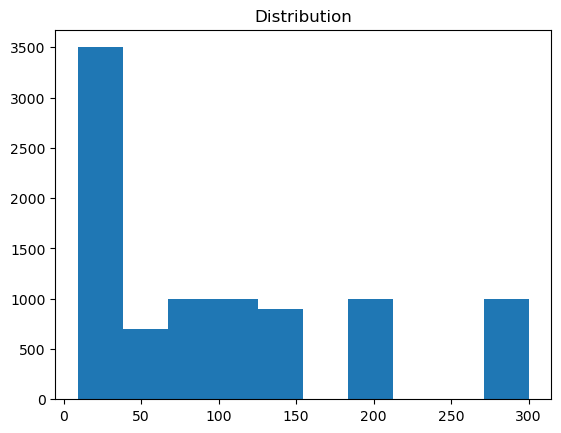

In [5]:
plt.figure()
plt.hist(lactate['Lactate'])
plt.title(f'Distribution')
plt.show()

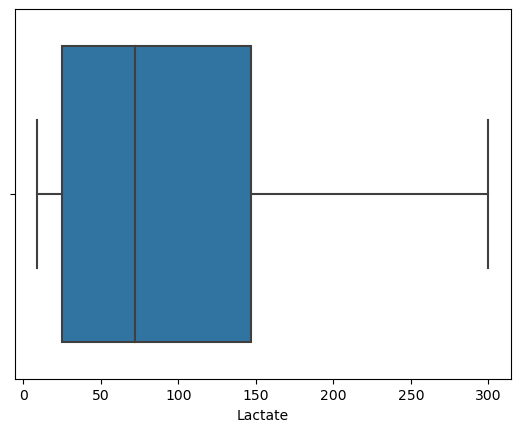

In [6]:
import seaborn as sns
plt.figure()
sns.boxplot(data=lactate, x='Lactate')
plt.show()

In [47]:
spectra = urea.iloc[:,3:]
spectra

,1352.0,1353.0,1354.0,1355.0,1356.0,1357.0,1358.0,1359.0,1360.0,1361.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,0.326777,0.327594,0.328574,0.329736,0.331045,0.332443,0.333808,0.335060,0.336272,0.337447,...,3.884846,3.891455,3.897297,3.902262,3.906273,3.909308,3.911418,3.912773,3.913718,3.914531
1,0.327103,0.327927,0.328911,0.330068,0.331363,0.332741,0.334091,0.335334,0.336545,0.337726,...,3.902861,3.909777,3.914507,3.917156,3.917897,3.916987,3.914795,3.911844,3.908879,3.906618
2,0.328717,0.329531,0.330507,0.331664,0.332967,0.334358,0.335716,0.336960,0.338168,0.339345,...,3.890589,3.900686,3.909336,3.916392,3.921788,3.925556,3.927858,3.929030,3.929648,3.930290
3,0.327485,0.328309,0.329295,0.330458,0.331761,0.333149,0.334505,0.335749,0.336956,0.338131,...,3.869466,3.876229,3.882600,3.888400,3.893481,3.897737,3.901139,3.903763,3.905857,3.907591
4,0.326867,0.327691,0.328678,0.329846,0.331160,0.332560,0.333924,0.335169,0.336374,0.337544,...,3.865839,3.870089,3.873236,3.875318,3.876395,3.876562,3.875976,3.874894,3.873732,3.872815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,0.325582,0.326674,0.327948,0.329424,0.331054,0.332754,0.334386,0.335833,0.337177,0.338424,...,4.500144,4.512827,4.526333,4.540226,4.554142,4.567758,4.580768,4.592866,4.603732,4.612983
9096,0.325347,0.326446,0.327726,0.329207,0.330841,0.332543,0.334175,0.335623,0.336967,0.338212,...,4.548688,4.554267,4.555407,4.552824,4.547324,4.539770,4.531062,4.522119,4.513868,4.507194
9097,0.325563,0.326648,0.327911,0.329370,0.330981,0.332661,0.334278,0.335718,0.337061,0.338311,...,4.504238,4.512583,4.517647,4.519844,4.519682,4.517728,4.514587,4.510887,4.507268,4.504331
9098,0.325854,0.326950,0.328228,0.329704,0.331331,0.333025,0.334650,0.336089,0.337429,0.338673,...,4.569032,4.576238,4.579017,4.578017,4.573987,4.567748,4.560176,4.552182,4.544703,4.538660


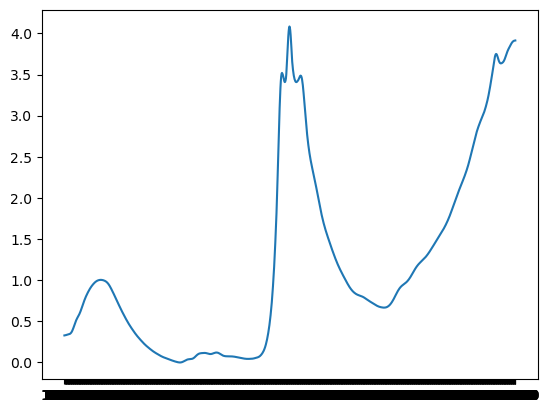

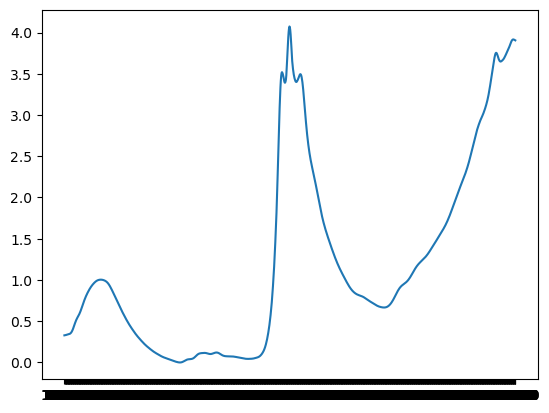

In [48]:
for i in range(2):
    plt.figure()
    plt.plot(spectra.iloc[i,:])
    plt.show()

In [15]:
lactate

,Lactate,1350.0,1351.0,1352.0,1353.0,1354.0,1355.0,1356.0,1357.0,1358.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,9.0,0.325606,0.326118,0.326777,0.327594,0.328574,0.329736,0.331045,0.332443,0.333808,...,3.884846,3.891455,3.897297,3.902262,3.906273,3.909308,3.911418,3.912773,3.913718,3.914531
1,9.0,0.325919,0.326437,0.327103,0.327927,0.328911,0.330068,0.331363,0.332741,0.334091,...,3.902861,3.909777,3.914507,3.917156,3.917897,3.916987,3.914795,3.911844,3.908879,3.906618
2,9.0,0.327546,0.328058,0.328717,0.329531,0.330507,0.331664,0.332967,0.334358,0.335716,...,3.890589,3.900686,3.909336,3.916392,3.921788,3.925556,3.927858,3.929030,3.929648,3.930290
3,9.0,0.326307,0.326820,0.327485,0.328309,0.329295,0.330458,0.331761,0.333149,0.334505,...,3.869466,3.876229,3.882600,3.888400,3.893481,3.897737,3.901139,3.903763,3.905857,3.907591
4,9.0,0.325683,0.326201,0.326867,0.327691,0.328678,0.329846,0.331160,0.332560,0.333924,...,3.865839,3.870089,3.873236,3.875318,3.876395,3.876562,3.875976,3.874894,3.873732,3.872815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,300.0,0.323957,0.324675,0.325582,0.326674,0.327948,0.329424,0.331054,0.332754,0.334386,...,4.500144,4.512827,4.526333,4.540226,4.554142,4.567758,4.580768,4.592866,4.603732,4.612983
9096,300.0,0.323710,0.324435,0.325347,0.326446,0.327726,0.329207,0.330841,0.332543,0.334175,...,4.548688,4.554267,4.555407,4.552824,4.547324,4.539770,4.531062,4.522119,4.513868,4.507194
9097,300.0,0.323934,0.324658,0.325563,0.326648,0.327911,0.329370,0.330981,0.332661,0.334278,...,4.504238,4.512583,4.517647,4.519844,4.519682,4.517728,4.514587,4.510887,4.507268,4.504331
9098,300.0,0.324222,0.324944,0.325854,0.326950,0.328228,0.329704,0.331331,0.333025,0.334650,...,4.569032,4.576238,4.579017,4.578017,4.573987,4.567748,4.560176,4.552182,4.544703,4.538660


In [16]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [17]:
train, test = model_selection.train_test_split(lactate, test_size=0.1, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 85.300746 - train R2 0.167676 — val RMSE 64.917971 - val R2 0.517924
Epoch  2 — train RMSE 63.712840 - train R2 0.535657 — val RMSE 40.864750 - val R2 0.808978
Epoch  3 — train RMSE 53.220217 - train R2 0.676004 — val RMSE 25.867819 - val R2 0.923457
Epoch  4 — train RMSE 49.406297 - train R2 0.720778 — val RMSE 27.312296 - val R2 0.914670
Epoch  5 — train RMSE 49.270164 - train R2 0.722314 — val RMSE 24.470781 - val R2 0.931501
Epoch  6 — train RMSE 47.344012 - train R2 0.743602 — val RMSE 20.901695 - val R2 0.950025
Epoch  7 — train RMSE 48.642689 - train R2 0.729342 — val RMSE 19.733115 - val R2 0.955457
Epoch  8 — train RMSE 47.616392 - train R2 0.740642 — val RMSE 17.387376 - val R2 0.965418
Epoch  9 — train RMSE 48.983973 - train R2 0.725531 — val RMSE 19.662605 - val R2 0.955775
Epoch 10 — train RMSE 48.265114 - train R2 0.733528 — val RMSE 20.209031 - val R2 0.953283
Epoch 11 — train RMSE 46.243009 - train R2 0.755388 — val RMSE 17.210161 - val R2 0.966119

KeyboardInterrupt: 

#### Urea

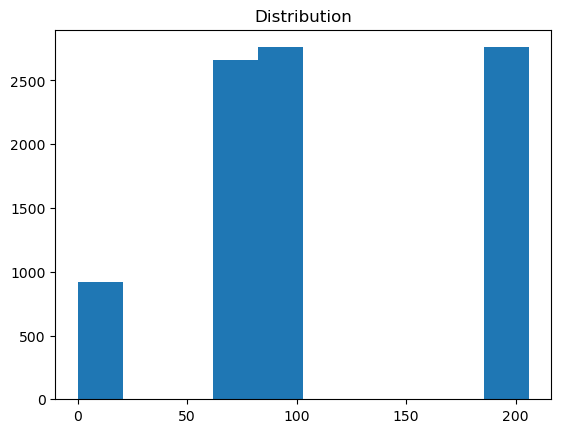

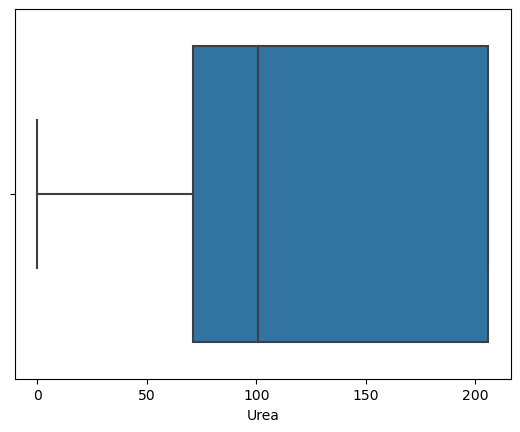

In [7]:
plt.figure()
plt.hist(urea['Urea'])
plt.title(f'Distribution')
plt.show()

import seaborn as sns
plt.figure()
sns.boxplot(data=urea, x='Urea')
plt.show()

In [13]:
urea['Urea'].value_counts()

101.0    2760
206.0    2760
71.0     2660
0.0       920
Name: Urea, dtype: int64

In [18]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of urea concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001
)

In [19]:
train, test = model_selection.train_test_split(urea, test_size=0.1, random_state=1, stratify= urea['Urea'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Urea'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 20, 8, True, False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 72.941657 - train R2 -0.189498 — val RMSE 53.437408 - val R2 0.361307
Epoch  2 — train RMSE 65.123902 - train R2 0.051817 — val RMSE 56.262258 - val R2 0.291996
Epoch  3 — train RMSE 64.347899 - train R2 0.074277 — val RMSE 49.787524 - val R2 0.445576
Epoch  4 — train RMSE 61.960860 - train R2 0.141685 — val RMSE 48.773918 - val R2 0.467921
Epoch  5 — train RMSE 62.039235 - train R2 0.139512 — val RMSE 52.156091 - val R2 0.391569
Epoch  6 — train RMSE 63.312308 - train R2 0.103837 — val RMSE 46.564806 - val R2 0.515028
Epoch  7 — train RMSE 60.310069 - train R2 0.186813 — val RMSE 51.834915 - val R2 0.399040


KeyboardInterrupt: 

#### Glucose

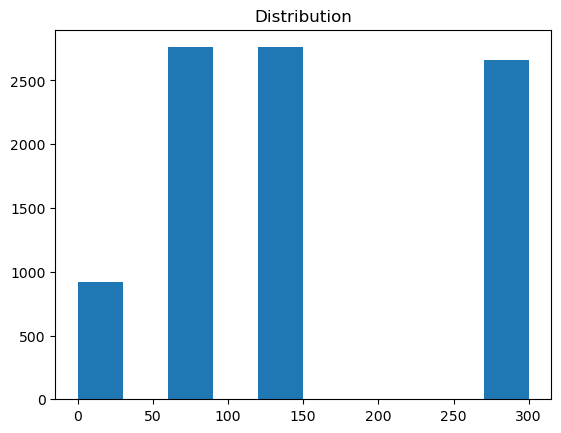

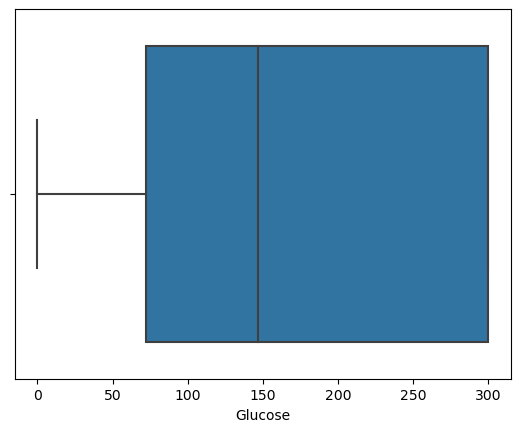

In [8]:
plt.figure()
plt.hist(glucose['Glucose'])
plt.title(f'Distribution')
plt.show()

import seaborn as sns
plt.figure()
sns.boxplot(data=glucose, x='Glucose')
plt.show()

In [14]:
glucose['Glucose'].value_counts()

147.0    2760
72.0     2660
300.0    2660
0.0       920
71.0      100
Name: Glucose, dtype: int64

In [ ]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of glucose concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.001
)

In [ ]:
train, test = model_selection.train_test_split(glucose, test_size=0.1, random_state=1, stratify= glucose['Glucose'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Glucose'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 50, 8, True)

## Preprocessed

In [ ]:
wavenumbers = X.columns.astype(float).values

# Stack each row as an rp.Spectrum, then combine into one container
spectra = [
    rs.Spectrum(spectral_data=row.values, spectral_axis=wavenumbers)
    for _, row in X.iterrows()
]
container = rs.SpectralContainer.from_stack(spectra)


pipeline = preprocessing.Pipeline([
    preprocessing.despike.WhitakerHayes(kernel_size=3, threshold=3.5),
    preprocessing.denoise.SavGol(window_length=11, polyorder=3),
    preprocessing.baseline.ARPLS(lam=1e5, diff_order=2),
    preprocessing.normalise.Vector(),
])

preprocessed = pipeline.apply(container)

clean_array = preprocessed.spectral_data

In [ ]:
X_clean = pd.DataFrame(data=clean_array, index=X.index, columns=wavenumbers)
X_clean

In [14]:
lactate_c = pd.concat([l, X_clean], axis=1)

urea_c = pd.concat([u, X_clean], axis=1)

glucose_c = pd.concat([g, X_clean], axis=1)

#### Lactate

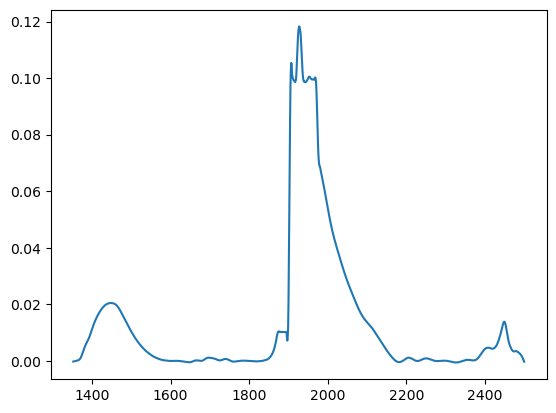

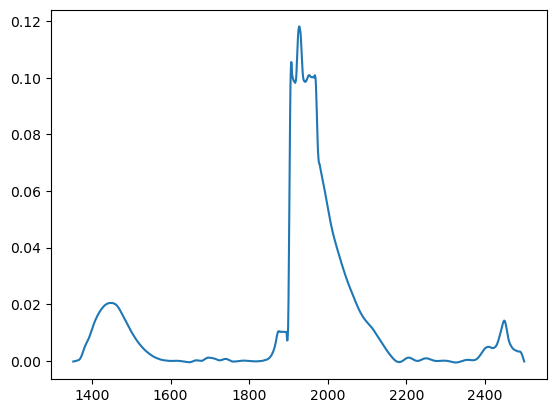

In [15]:
spectra = lactate_c.iloc[:,3:]
for i in range(2):
    plt.figure()
    plt.plot(spectra.iloc[i,:])
    plt.show()

In [25]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

In [27]:
train, test = model_selection.train_test_split(lactate_c, test_size=0.1, random_state=1, stratify= lactate_c['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model_earlystop(configs, train, validation, 50, 8, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 87.374720 - train R2 0.126713 — val RMSE 60.866551 - val R2 0.576217
Epoch  2 — train RMSE 65.948651 - train R2 0.502495 — val RMSE 43.443534 - val R2 0.784108
Epoch  3 — train RMSE 59.370458 - train R2 0.596794 — val RMSE 38.827842 - val R2 0.827546
Epoch  4 — train RMSE 53.664650 - train R2 0.670570 — val RMSE 33.879315 - val R2 0.868703
Epoch  5 — train RMSE 52.036906 - train R2 0.690252 — val RMSE 30.146779 - val R2 0.896040
Epoch  6 — train RMSE 53.268393 - train R2 0.675418 — val RMSE 30.287954 - val R2 0.895064
Epoch  7 — train RMSE 52.250616 - train R2 0.687703 — val RMSE 32.041029 - val R2 0.882565
Epoch  8 — train RMSE 50.332366 - train R2 0.710212 — val RMSE 27.485846 - val R2 0.913582
Epoch  9 — train RMSE 49.447240 - train R2 0.720315 — val RMSE 29.786048 - val R2 0.898513
Epoch 10 — train RMSE 52.179708 - train R2 0.688549 — val RMSE 27.491890 - val R2 0.913544
Epoch 11 — train RMSE 50.146701 - train R2 0.712346 — val RMSE 27.333944 - val R2 0.914535